In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from typing import List, Optional, Union
from typing import Tuple
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm

def set_seed(seed=42):
    # Python built-in random
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

# Call this at the beginning of your script
set_seed(42)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 2048
EPOCHS = 500 # Set the total number of epochs you want to train for
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [3]:
df_train = pd.read_csv("./KDD/KDDTrain.csv")
#df_train = df_train.drop(columns=['service', 'protocol_type','flag'])
df_train['label'] = df_train['label'].apply(lambda x: 0 if x == 'normal' else 1)
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [4]:
df_test = pd.read_csv("./KDD/KDDTest.csv")
#df_test = df_test.drop(columns=['service', 'protocol_type','flag'])
df_test['label'] = df_test['label'].apply(lambda x: 0 if x == 'normal' else 1)
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,1


In [5]:
# Columns you want to encode instead of dropping
encode_cols = ['service', 'protocol_type', 'flag']

label_encoders = {}
for col in encode_cols:
    le = LabelEncoder()
    # Fit on combined train + test to ensure consistency
    combined_data = pd.concat([df_train[col], df_test[col]], axis=0)
    le.fit(combined_data)

    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])

    label_encoders[col] = le  # Save encoder for later use

In [6]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [7]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,49,1,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
1,0,1,49,1,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1
2,2,1,20,9,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0
3,0,0,14,9,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1
4,1,1,60,2,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,1


In [8]:
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']

X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']

X_train = X_train.loc[:, (X_train >= 0).all()]
X_train = np.log1p(X_train)

X_test = X_test.loc[:, (X_test >= 0).all()]
X_test = np.log1p(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("x_train shape:",X_train_scaled.shape,"| y_train shape:",y_train.shape,"| x_test shape:",X_test_scaled.shape,"| y_test shape:",y_test.shape)

x_train shape: (125973, 41) | y_train shape: (125973,) | x_test shape: (22544, 41) | y_test shape: (22544,)


In [9]:
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [10]:
class IndexedDataset(Dataset):
    def __init__(self, X_tensor, y_tensor):
        self.X = X_tensor
        self.y = y_tensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], idx

train_dataset = IndexedDataset(x_train_tensor,y_train_tensor)
test_dataset = IndexedDataset(x_test_tensor,y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size)

# Initialize per-sample weights (1.0 for all)
sample_weights = torch.ones(len(x_train_tensor), dtype=torch.float32)
sample_weights = sample_weights.to(device)

In [11]:
class ActivationNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.layer = nn.Linear(num_features, 32)
        self.y0_head = nn.Linear(32, num_features)
        self.m_head  = nn.Linear(32, num_features)
        self.x0_head = nn.Linear(32, num_features)
        self.combine = nn.Linear(3 * num_features, 3 * num_features)

    def forward(self, x):
        h = self.layer(x)
        h = torch.tanh(h)
        
        y0 = self.y0_head(h)
        m  = self.m_head(h)
        x0 = self.x0_head(h)
        
        params = torch.cat([y0, m, x0], dim=-1)
        params = self.combine(params)
        
        y0, m, x0 = torch.split(params, self.num_features, dim=1)
        
        y = y0 + m * (x - x0)
        
        return [x, y], [x0, y0, m]

In [12]:
class KDD_Model(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.layer1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
        self.activation1 = ActivationNet(num_features=128)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.activation2 = ActivationNet(num_features=64)
        
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(num_features=32)
        self.activation3 = ActivationNet(num_features=32)

        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.bn1(self.layer1(x))
        out1, internal_out1 = self.activation1(x)
        
        x = self.bn2(self.layer2(out1[1]))
        out2, internal_out2 = self.activation2(x)

        x = self.bn3(self.layer3(out2[1]))
        out3, internal_out3 = self.activation3(x)

        x = self.output_layer(out3[1])
        return x, [out1, out2, out3], [internal_out1, internal_out2, internal_out3]

In [13]:
# --- File Paths ---
BEST_MODEL_PATH = "./KDD/results_mv_2d/best_model_f1.pth"
CHECKPOINT_PATH = "./KDD/results_mv_2d/training_checkpoint.pth"
LOGS_PATH = "./KDD/results_mv_2d/training_logs.csv"

In [14]:
input_features = X_train_scaled.shape[1]

model = KDD_Model(input_features)
model = model.to(device)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction='none')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

In [15]:
# Checkpoint Loading (Resume Logic)

THRESH = 0.5  # <- your decision threshold
start_epoch = 0
best_f1_score = 0.0
history = []

# Check if a checkpoint file exists
if os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found! Resuming training from {CHECKPOINT_PATH}")
    # Load the checkpoint
    checkpoint = torch.load(CHECKPOINT_PATH, weights_only=False)
    
    # Restore the state
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    
    # Find the best F1 score from the loaded history to continue tracking
    if history:
        # This gets the 'test_f1' value from each dictionary in the history list
        best_f1_score = max([epoch_data.get('test_f1', 0) for epoch_data in history])
    
    print(f"Resuming from epoch {start_epoch}. Best Test F1 so far: {best_f1_score:.4f}")
else:
    print("No checkpoint found. Starting training from scratch.")

Checkpoint found! Resuming training from ./KDD/results_mv_2d/training_checkpoint.pth
Resuming from epoch 500. Best Test F1 so far: 0.9348


In [16]:
def update_sample_weights(
    model: nn.Module,
    data_loader: DataLoader,
    current_weights: torch.Tensor,
    device: torch.device,
    threshold: float = 0.5,
    increase_factor: float = 1.2,
    decrease_factor: float = 0.9,
    min_weight: float = 0.1,
    max_weight: float = 5.0
) -> torch.Tensor:

    model.eval()  # Set model to evaluation mode for consistent predictions
    
    all_preds = []
    all_labels = []
    all_indices = []
    
    with torch.no_grad():
        # Loop through the entire dataset to get predictions
        for inputs, labels, indices in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs, _, _ = model(inputs)
            preds = (torch.sigmoid(outputs) > threshold).float()
            
            all_preds.append(preds.view(-1))
            all_labels.append(labels.view(-1))
            all_indices.append(indices.to(device)) # Keep indices on the same device
            
    # Concatenate all batch results into single tensors
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_indices = torch.cat(all_indices)

    # Identify incorrect and correct predictions using a boolean mask
    incorrect_mask = (all_preds != all_labels)
    correct_mask = ~incorrect_mask

    # Use the boolean masks to get the global indices of the samples
    incorrect_indices = all_indices[incorrect_mask]
    correct_indices = all_indices[correct_mask]

    # Update weights for the identified samples
    # Note: We update the original 'current_weights' tensor
    current_weights[incorrect_indices] *= increase_factor
    current_weights[correct_indices] *= decrease_factor
    
    # Clamp the weights to a reasonable range and return
    return current_weights.clamp(min=min_weight, max=max_weight)

In [17]:
# Evaluation Function

@torch.no_grad()
def evaluate_model_threshold(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=f"Testing", leave=True)

    for inputs, labels, _ in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
        outputs, _, _ = model(inputs)

        # logits -> probs
        probs = torch.sigmoid(outputs.view(-1))
        preds = (probs >= THRESH).long()

        # per-sample loss (no weights on test unless you have a test weight vector)
        losses = loss_fn(outputs.view(-1), labels.float()).mean()

        batch_size = labels.size(0)
        total_loss += losses.item() * batch_size
        total_count += batch_size

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(loss=total_loss / total_count)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy via thresholded preds
    acc = (all_preds == all_labels).mean()

    # Macro P/R/F1 (over classes 0 and 1)
    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    avg_loss = total_loss / total_count
    return avg_loss, acc, p, r, f1

In [18]:
# ---------------- Main Training Loop ----------------
for epoch in range(start_epoch, EPOCHS):
    model.train()

    # running stats for TRAIN (weighted loss averaged by total weight)
    total_weighted_loss = 0.0
    total_count = 0.0

    train_all_preds = []
    train_all_labels = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)

    for inputs, labels, indices in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1).long()
        indices = indices.to(device)

        # ---- Forward ----
        outputs, _, _ = model(inputs)  # shape [B, 1] or [B]
        logits = outputs.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs >= THRESH).long()

        # per-sample loss (assumes BCEWithLogitsLoss(reduction='none'))
        losses = loss_fn(logits, labels.float()).view(-1)

        # weights
        batch_weights = sample_weights[indices]  # shape [B]
        weighted_loss = (losses * batch_weights).mean()

        # ---- Backward ----
        optimizer.zero_grad()
        weighted_loss.backward()
        optimizer.step()

        # ---- Accumulate epoch stats ----
        batch_size = labels.size(0)
        total_weighted_loss += weighted_loss.item() * batch_size
        total_count += batch_size

        train_all_preds.append(preds.detach().cpu())
        train_all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(weighted_loss=total_weighted_loss / total_count)

    # Update weights: increase for misclassified
    sample_weights = update_sample_weights(
        model=model,
        data_loader=train_loader,
        current_weights=sample_weights,
        device=device,
        threshold=THRESH
    )

    # ---- TRAIN epoch metrics (threshold-based) ----
    train_all_preds = torch.cat(train_all_preds).numpy()
    train_all_labels = torch.cat(train_all_labels).numpy()

    train_weighted_loss = total_weighted_loss / total_count
    train_acc = (train_all_preds == train_all_labels).mean()
    train_p, train_r, train_f1, _ = precision_recall_fscore_support(
        train_all_labels, train_all_preds, average='macro', zero_division=0
    )

    # ---- TEST evaluation (single pass, threshold-based) ----
    test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        model, test_loader, loss_fn, device
    )

    # ---- Logging ----
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {train_weighted_loss:.4f}, Acc(th={THRESH}): {train_acc:.4f}, "
        f"P: {train_p:.4f}, R: {train_r:.4f}, F1: {train_f1:.4f} | "
        f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
        f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
    )

    epoch_data = {
        'epoch': epoch + 1,
        'train_loss': train_weighted_loss,
        'train_accuracy_threshold': train_acc,
        'train_precision': train_p,
        'train_recall': train_r,
        'train_f1': train_f1,
        'test_loss': test_loss,
        'test_accuracy_threshold': test_acc,
        'test_precision': test_p,
        'test_recall': test_r,
        'test_f1': test_f1,
        'threshold': THRESH,
    }
    history.append(epoch_data)
    pd.DataFrame(history).to_csv(LOGS_PATH, index=False)

    # ---- Save the Best Model by Test F1 ----
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"🎉 New best model saved with Test F1 Score: {best_f1_score:.4f}")

    # ---- Checkpoint every epoch ----
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history
    }, CHECKPOINT_PATH)

print("="*60)
print("Training finished!")
print(f"Best model saved to: {BEST_MODEL_PATH} (Test F1: {best_f1_score:.4f})")
print(f"Full training logs saved to: {LOGS_PATH}")
print(f"Final checkpoint for resumption saved to: {CHECKPOINT_PATH}")

Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.75it/s, loss=0.966]


Epoch 1/500 | Train Loss: 0.0747, Acc(th=0.5): 0.9683, P: 0.9698, R: 0.9669, F1: 0.9680 | Test Loss: 0.9655, Acc(th=0.5): 0.7927, P: 0.8252, R: 0.8144, F1: 0.7923
🎉 New best model saved with Test F1 Score: 0.7923


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.43it/s, loss=0.974]


Epoch 2/500 | Train Loss: 0.0236, Acc(th=0.5): 0.9926, P: 0.9927, R: 0.9925, F1: 0.9926 | Test Loss: 0.9738, Acc(th=0.5): 0.8034, P: 0.8315, R: 0.8238, F1: 0.8031
🎉 New best model saved with Test F1 Score: 0.8031


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.92it/s, loss=1.01]


Epoch 3/500 | Train Loss: 0.0209, Acc(th=0.5): 0.9940, P: 0.9941, R: 0.9939, F1: 0.9940 | Test Loss: 1.0104, Acc(th=0.5): 0.8016, P: 0.8301, R: 0.8221, F1: 0.8014


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.72it/s, loss=0.896]


Epoch 4/500 | Train Loss: 0.0204, Acc(th=0.5): 0.9940, P: 0.9941, R: 0.9939, F1: 0.9940 | Test Loss: 0.8959, Acc(th=0.5): 0.8001, P: 0.8287, R: 0.8206, F1: 0.7998


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.54it/s, loss=0.803]


Epoch 5/500 | Train Loss: 0.0181, Acc(th=0.5): 0.9951, P: 0.9951, R: 0.9950, F1: 0.9951 | Test Loss: 0.8025, Acc(th=0.5): 0.8292, P: 0.8471, R: 0.8461, F1: 0.8292
🎉 New best model saved with Test F1 Score: 0.8292


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.77it/s, loss=0.819]


Epoch 6/500 | Train Loss: 0.0182, Acc(th=0.5): 0.9946, P: 0.9945, R: 0.9946, F1: 0.9946 | Test Loss: 0.8192, Acc(th=0.5): 0.7713, P: 0.8119, R: 0.7954, F1: 0.7704


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.13it/s, loss=0.827]


Epoch 7/500 | Train Loss: 0.0183, Acc(th=0.5): 0.9936, P: 0.9936, R: 0.9936, F1: 0.9936 | Test Loss: 0.8272, Acc(th=0.5): 0.7944, P: 0.8213, R: 0.8143, F1: 0.7942


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.62it/s, loss=0.997]


Epoch 8/500 | Train Loss: 0.0176, Acc(th=0.5): 0.9935, P: 0.9934, R: 0.9936, F1: 0.9935 | Test Loss: 0.9972, Acc(th=0.5): 0.8446, P: 0.8543, R: 0.8580, F1: 0.8445
🎉 New best model saved with Test F1 Score: 0.8445


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.47it/s, loss=0.841]


Epoch 9/500 | Train Loss: 0.0216, Acc(th=0.5): 0.9915, P: 0.9915, R: 0.9914, F1: 0.9915 | Test Loss: 0.8409, Acc(th=0.5): 0.8194, P: 0.8413, R: 0.8377, F1: 0.8193


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.62it/s, loss=0.833]


Epoch 10/500 | Train Loss: 0.0229, Acc(th=0.5): 0.9899, P: 0.9897, R: 0.9899, F1: 0.9898 | Test Loss: 0.8333, Acc(th=0.5): 0.7830, P: 0.8199, R: 0.8061, F1: 0.7824


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.80it/s, loss=0.565]


Epoch 11/500 | Train Loss: 0.0200, Acc(th=0.5): 0.9909, P: 0.9906, R: 0.9912, F1: 0.9909 | Test Loss: 0.5648, Acc(th=0.5): 0.8509, P: 0.8588, R: 0.8634, F1: 0.8507
🎉 New best model saved with Test F1 Score: 0.8507


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.43it/s, loss=1.03]


Epoch 12/500 | Train Loss: 0.0191, Acc(th=0.5): 0.9909, P: 0.9906, R: 0.9910, F1: 0.9908 | Test Loss: 1.0305, Acc(th=0.5): 0.8050, P: 0.8192, R: 0.8201, F1: 0.8050


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.09it/s, loss=0.763]


Epoch 13/500 | Train Loss: 0.0184, Acc(th=0.5): 0.9914, P: 0.9912, R: 0.9914, F1: 0.9913 | Test Loss: 0.7632, Acc(th=0.5): 0.8337, P: 0.8504, R: 0.8502, F1: 0.8337


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.97it/s, loss=0.909]


Epoch 14/500 | Train Loss: 0.0198, Acc(th=0.5): 0.9897, P: 0.9895, R: 0.9899, F1: 0.9897 | Test Loss: 0.9090, Acc(th=0.5): 0.7778, P: 0.8164, R: 0.8014, F1: 0.7770


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.00it/s, loss=0.839]


Epoch 15/500 | Train Loss: 0.0168, Acc(th=0.5): 0.9906, P: 0.9904, R: 0.9908, F1: 0.9906 | Test Loss: 0.8387, Acc(th=0.5): 0.7981, P: 0.8277, R: 0.8190, F1: 0.7978


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.37it/s, loss=0.958]


Epoch 16/500 | Train Loss: 0.0179, Acc(th=0.5): 0.9875, P: 0.9872, R: 0.9877, F1: 0.9875 | Test Loss: 0.9577, Acc(th=0.5): 0.8633, P: 0.8696, R: 0.8751, F1: 0.8631
🎉 New best model saved with Test F1 Score: 0.8631


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.93it/s, loss=0.537]


Epoch 17/500 | Train Loss: 0.0193, Acc(th=0.5): 0.9865, P: 0.9863, R: 0.9866, F1: 0.9865 | Test Loss: 0.5372, Acc(th=0.5): 0.7906, P: 0.8233, R: 0.8124, F1: 0.7902


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 44.10it/s, loss=0.368]


Epoch 18/500 | Train Loss: 0.0197, Acc(th=0.5): 0.9848, P: 0.9843, R: 0.9852, F1: 0.9847 | Test Loss: 0.3683, Acc(th=0.5): 0.8606, P: 0.8616, R: 0.8686, F1: 0.8600


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.02it/s, loss=0.694]


Epoch 19/500 | Train Loss: 0.0193, Acc(th=0.5): 0.9854, P: 0.9852, R: 0.9854, F1: 0.9853 | Test Loss: 0.6937, Acc(th=0.5): 0.8104, P: 0.8348, R: 0.8296, F1: 0.8103


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.90it/s, loss=0.561]


Epoch 20/500 | Train Loss: 0.0176, Acc(th=0.5): 0.9881, P: 0.9879, R: 0.9884, F1: 0.9881 | Test Loss: 0.5612, Acc(th=0.5): 0.8351, P: 0.8492, R: 0.8505, F1: 0.8351


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.61it/s, loss=0.534]


Epoch 21/500 | Train Loss: 0.0178, Acc(th=0.5): 0.9862, P: 0.9859, R: 0.9863, F1: 0.9861 | Test Loss: 0.5338, Acc(th=0.5): 0.8266, P: 0.8456, R: 0.8439, F1: 0.8265


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.40it/s, loss=0.635]


Epoch 22/500 | Train Loss: 0.0168, Acc(th=0.5): 0.9890, P: 0.9887, R: 0.9892, F1: 0.9889 | Test Loss: 0.6349, Acc(th=0.5): 0.8713, P: 0.8770, R: 0.8829, F1: 0.8711
🎉 New best model saved with Test F1 Score: 0.8711


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.28it/s, loss=0.591]


Epoch 23/500 | Train Loss: 0.0151, Acc(th=0.5): 0.9911, P: 0.9908, R: 0.9912, F1: 0.9910 | Test Loss: 0.5912, Acc(th=0.5): 0.8603, P: 0.8681, R: 0.8729, F1: 0.8602


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.69it/s, loss=0.737]


Epoch 24/500 | Train Loss: 0.0165, Acc(th=0.5): 0.9907, P: 0.9906, R: 0.9908, F1: 0.9907 | Test Loss: 0.7366, Acc(th=0.5): 0.8238, P: 0.8432, R: 0.8412, F1: 0.8238


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.74it/s, loss=0.541]


Epoch 25/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9879, P: 0.9876, R: 0.9880, F1: 0.9878 | Test Loss: 0.5409, Acc(th=0.5): 0.8023, P: 0.8292, R: 0.8223, F1: 0.8021


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.12it/s, loss=0.728]


Epoch 26/500 | Train Loss: 0.0157, Acc(th=0.5): 0.9869, P: 0.9866, R: 0.9872, F1: 0.9869 | Test Loss: 0.7276, Acc(th=0.5): 0.7984, P: 0.8257, R: 0.8185, F1: 0.7982


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.21it/s, loss=0.552]


Epoch 27/500 | Train Loss: 0.0139, Acc(th=0.5): 0.9927, P: 0.9925, R: 0.9927, F1: 0.9926 | Test Loss: 0.5521, Acc(th=0.5): 0.7850, P: 0.8215, R: 0.8080, F1: 0.7844


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.68it/s, loss=0.998]


Epoch 28/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9860, P: 0.9856, R: 0.9862, F1: 0.9859 | Test Loss: 0.9981, Acc(th=0.5): 0.7988, P: 0.8276, R: 0.8194, F1: 0.7985


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.14it/s, loss=0.921]


Epoch 29/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9858, P: 0.9854, R: 0.9862, F1: 0.9857 | Test Loss: 0.9205, Acc(th=0.5): 0.8471, P: 0.8576, R: 0.8609, F1: 0.8470


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.31it/s, loss=0.588]


Epoch 30/500 | Train Loss: 0.0170, Acc(th=0.5): 0.9811, P: 0.9808, R: 0.9814, F1: 0.9810 | Test Loss: 0.5877, Acc(th=0.5): 0.8011, P: 0.8288, R: 0.8213, F1: 0.8008


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.79it/s, loss=0.568]


Epoch 31/500 | Train Loss: 0.0163, Acc(th=0.5): 0.9831, P: 0.9829, R: 0.9832, F1: 0.9830 | Test Loss: 0.5677, Acc(th=0.5): 0.7494, P: 0.7987, R: 0.7759, F1: 0.7476


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.74it/s, loss=0.705]


Epoch 32/500 | Train Loss: 0.0178, Acc(th=0.5): 0.9805, P: 0.9804, R: 0.9804, F1: 0.9804 | Test Loss: 0.7054, Acc(th=0.5): 0.7959, P: 0.8257, R: 0.8168, F1: 0.7956


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.54it/s, loss=0.547]


Epoch 33/500 | Train Loss: 0.0161, Acc(th=0.5): 0.9840, P: 0.9835, R: 0.9845, F1: 0.9839 | Test Loss: 0.5465, Acc(th=0.5): 0.8534, P: 0.8618, R: 0.8663, F1: 0.8532


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.73it/s, loss=0.478]


Epoch 34/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9857, P: 0.9854, R: 0.9859, F1: 0.9856 | Test Loss: 0.4782, Acc(th=0.5): 0.8056, P: 0.8294, R: 0.8245, F1: 0.8055


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.55it/s, loss=0.528]


Epoch 35/500 | Train Loss: 0.0186, Acc(th=0.5): 0.9746, P: 0.9749, R: 0.9740, F1: 0.9744 | Test Loss: 0.5283, Acc(th=0.5): 0.8406, P: 0.8517, R: 0.8547, F1: 0.8406


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.57it/s, loss=0.755]


Epoch 36/500 | Train Loss: 0.0198, Acc(th=0.5): 0.9735, P: 0.9736, R: 0.9732, F1: 0.9734 | Test Loss: 0.7553, Acc(th=0.5): 0.7724, P: 0.8131, R: 0.7966, F1: 0.7715


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.42it/s, loss=0.664]


Epoch 37/500 | Train Loss: 0.0167, Acc(th=0.5): 0.9821, P: 0.9819, R: 0.9822, F1: 0.9820 | Test Loss: 0.6639, Acc(th=0.5): 0.7998, P: 0.8273, R: 0.8200, F1: 0.7996


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.41it/s, loss=0.996]


Epoch 38/500 | Train Loss: 0.0176, Acc(th=0.5): 0.9832, P: 0.9831, R: 0.9831, F1: 0.9831 | Test Loss: 0.9955, Acc(th=0.5): 0.7876, P: 0.8220, R: 0.8099, F1: 0.7871


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.76it/s, loss=0.629]


Epoch 39/500 | Train Loss: 0.0180, Acc(th=0.5): 0.9801, P: 0.9798, R: 0.9802, F1: 0.9800 | Test Loss: 0.6288, Acc(th=0.5): 0.7483, P: 0.8006, R: 0.7756, F1: 0.7463


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.61it/s, loss=1.1]


Epoch 40/500 | Train Loss: 0.0174, Acc(th=0.5): 0.9788, P: 0.9782, R: 0.9794, F1: 0.9787 | Test Loss: 1.0971, Acc(th=0.5): 0.8346, P: 0.8490, R: 0.8501, F1: 0.8346


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.11it/s, loss=0.57]


Epoch 41/500 | Train Loss: 0.0172, Acc(th=0.5): 0.9785, P: 0.9779, R: 0.9790, F1: 0.9784 | Test Loss: 0.5699, Acc(th=0.5): 0.7533, P: 0.8038, R: 0.7801, F1: 0.7515


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.24it/s, loss=0.53]


Epoch 42/500 | Train Loss: 0.0191, Acc(th=0.5): 0.9746, P: 0.9740, R: 0.9755, F1: 0.9746 | Test Loss: 0.5298, Acc(th=0.5): 0.8058, P: 0.8312, R: 0.8253, F1: 0.8057


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.48it/s, loss=0.352]


Epoch 43/500 | Train Loss: 0.0187, Acc(th=0.5): 0.9747, P: 0.9741, R: 0.9755, F1: 0.9746 | Test Loss: 0.3524, Acc(th=0.5): 0.8958, P: 0.8928, R: 0.8979, F1: 0.8946
🎉 New best model saved with Test F1 Score: 0.8946


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.02it/s, loss=0.497]


Epoch 44/500 | Train Loss: 0.0213, Acc(th=0.5): 0.9734, P: 0.9730, R: 0.9737, F1: 0.9733 | Test Loss: 0.4975, Acc(th=0.5): 0.7956, P: 0.8238, R: 0.8160, F1: 0.7953


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.38it/s, loss=0.601]


Epoch 45/500 | Train Loss: 0.0191, Acc(th=0.5): 0.9778, P: 0.9773, R: 0.9783, F1: 0.9777 | Test Loss: 0.6005, Acc(th=0.5): 0.7571, P: 0.8071, R: 0.7837, F1: 0.7554


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.13it/s, loss=0.493]


Epoch 46/500 | Train Loss: 0.0189, Acc(th=0.5): 0.9806, P: 0.9800, R: 0.9814, F1: 0.9806 | Test Loss: 0.4934, Acc(th=0.5): 0.8816, P: 0.8838, R: 0.8910, F1: 0.8812


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.00it/s, loss=0.487]


Epoch 47/500 | Train Loss: 0.0186, Acc(th=0.5): 0.9828, P: 0.9823, R: 0.9835, F1: 0.9828 | Test Loss: 0.4873, Acc(th=0.5): 0.8510, P: 0.8621, R: 0.8652, F1: 0.8510


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.82it/s, loss=0.541]


Epoch 48/500 | Train Loss: 0.0197, Acc(th=0.5): 0.9764, P: 0.9758, R: 0.9771, F1: 0.9763 | Test Loss: 0.5406, Acc(th=0.5): 0.8228, P: 0.8375, R: 0.8383, F1: 0.8228


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.41it/s, loss=0.599]


Epoch 49/500 | Train Loss: 0.0200, Acc(th=0.5): 0.9797, P: 0.9791, R: 0.9803, F1: 0.9796 | Test Loss: 0.5990, Acc(th=0.5): 0.8341, P: 0.8391, R: 0.8446, F1: 0.8339


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.35it/s, loss=0.451]


Epoch 50/500 | Train Loss: 0.0211, Acc(th=0.5): 0.9721, P: 0.9715, R: 0.9727, F1: 0.9720 | Test Loss: 0.4511, Acc(th=0.5): 0.8435, P: 0.8445, R: 0.8511, F1: 0.8428


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.12it/s, loss=0.589]


Epoch 51/500 | Train Loss: 0.0203, Acc(th=0.5): 0.9777, P: 0.9770, R: 0.9786, F1: 0.9776 | Test Loss: 0.5890, Acc(th=0.5): 0.8665, P: 0.8648, R: 0.8717, F1: 0.8655


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.99it/s, loss=0.521]


Epoch 52/500 | Train Loss: 0.0196, Acc(th=0.5): 0.9789, P: 0.9786, R: 0.9792, F1: 0.9789 | Test Loss: 0.5206, Acc(th=0.5): 0.7770, P: 0.8080, R: 0.7982, F1: 0.7766


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.90it/s, loss=0.384]


Epoch 53/500 | Train Loss: 0.0201, Acc(th=0.5): 0.9780, P: 0.9775, R: 0.9784, F1: 0.9779 | Test Loss: 0.3837, Acc(th=0.5): 0.8868, P: 0.8856, R: 0.8929, F1: 0.8860


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.86it/s, loss=0.542]


Epoch 54/500 | Train Loss: 0.0194, Acc(th=0.5): 0.9815, P: 0.9810, R: 0.9821, F1: 0.9815 | Test Loss: 0.5423, Acc(th=0.5): 0.8694, P: 0.8733, R: 0.8798, F1: 0.8691


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.95it/s, loss=0.466]


Epoch 55/500 | Train Loss: 0.0205, Acc(th=0.5): 0.9800, P: 0.9797, R: 0.9801, F1: 0.9799 | Test Loss: 0.4664, Acc(th=0.5): 0.7679, P: 0.8120, R: 0.7930, F1: 0.7667


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.98it/s, loss=0.676]


Epoch 56/500 | Train Loss: 0.0226, Acc(th=0.5): 0.9733, P: 0.9727, R: 0.9740, F1: 0.9732 | Test Loss: 0.6763, Acc(th=0.5): 0.8369, P: 0.8398, R: 0.8460, F1: 0.8364


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.62it/s, loss=0.422]


Epoch 57/500 | Train Loss: 0.0211, Acc(th=0.5): 0.9799, P: 0.9794, R: 0.9807, F1: 0.9799 | Test Loss: 0.4221, Acc(th=0.5): 0.7869, P: 0.8228, R: 0.8096, F1: 0.7863


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.10it/s, loss=0.597]


Epoch 58/500 | Train Loss: 0.0195, Acc(th=0.5): 0.9826, P: 0.9821, R: 0.9830, F1: 0.9825 | Test Loss: 0.5970, Acc(th=0.5): 0.8451, P: 0.8470, R: 0.8536, F1: 0.8446


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.02it/s, loss=0.925]


Epoch 59/500 | Train Loss: 0.0181, Acc(th=0.5): 0.9874, P: 0.9871, R: 0.9877, F1: 0.9874 | Test Loss: 0.9250, Acc(th=0.5): 0.7873, P: 0.8218, R: 0.8097, F1: 0.7868


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.35it/s, loss=0.672]


Epoch 60/500 | Train Loss: 0.0194, Acc(th=0.5): 0.9802, P: 0.9797, R: 0.9808, F1: 0.9802 | Test Loss: 0.6720, Acc(th=0.5): 0.8579, P: 0.8653, R: 0.8703, F1: 0.8578


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.92it/s, loss=0.647]


Epoch 61/500 | Train Loss: 0.0207, Acc(th=0.5): 0.9821, P: 0.9817, R: 0.9825, F1: 0.9820 | Test Loss: 0.6468, Acc(th=0.5): 0.7825, P: 0.8182, R: 0.8052, F1: 0.7819


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.93it/s, loss=0.686]


Epoch 62/500 | Train Loss: 0.0208, Acc(th=0.5): 0.9783, P: 0.9778, R: 0.9789, F1: 0.9782 | Test Loss: 0.6860, Acc(th=0.5): 0.8207, P: 0.8411, R: 0.8385, F1: 0.8207


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.79it/s, loss=0.361]


Epoch 63/500 | Train Loss: 0.0227, Acc(th=0.5): 0.9749, P: 0.9743, R: 0.9758, F1: 0.9748 | Test Loss: 0.3612, Acc(th=0.5): 0.8510, P: 0.8591, R: 0.8637, F1: 0.8509


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.58it/s, loss=0.484]


Epoch 64/500 | Train Loss: 0.0220, Acc(th=0.5): 0.9767, P: 0.9762, R: 0.9773, F1: 0.9766 | Test Loss: 0.4840, Acc(th=0.5): 0.8653, P: 0.8640, R: 0.8710, F1: 0.8645


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.94it/s, loss=0.605]


Epoch 65/500 | Train Loss: 0.0212, Acc(th=0.5): 0.9801, P: 0.9802, R: 0.9799, F1: 0.9800 | Test Loss: 0.6052, Acc(th=0.5): 0.7325, P: 0.7920, R: 0.7616, F1: 0.7295


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.72it/s, loss=0.437]


Epoch 66/500 | Train Loss: 0.0218, Acc(th=0.5): 0.9798, P: 0.9793, R: 0.9802, F1: 0.9797 | Test Loss: 0.4373, Acc(th=0.5): 0.8594, P: 0.8652, R: 0.8709, F1: 0.8592


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.91it/s, loss=0.42]


Epoch 67/500 | Train Loss: 0.0216, Acc(th=0.5): 0.9826, P: 0.9824, R: 0.9827, F1: 0.9825 | Test Loss: 0.4201, Acc(th=0.5): 0.7631, P: 0.8046, R: 0.7875, F1: 0.7620


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.20it/s, loss=0.453]


Epoch 68/500 | Train Loss: 0.0218, Acc(th=0.5): 0.9805, P: 0.9800, R: 0.9810, F1: 0.9805 | Test Loss: 0.4531, Acc(th=0.5): 0.8756, P: 0.8789, R: 0.8857, F1: 0.8753


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.44it/s, loss=0.48]


Epoch 69/500 | Train Loss: 0.0229, Acc(th=0.5): 0.9801, P: 0.9796, R: 0.9806, F1: 0.9800 | Test Loss: 0.4804, Acc(th=0.5): 0.8050, P: 0.8262, R: 0.8229, F1: 0.8049


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.37it/s, loss=0.547]


Epoch 70/500 | Train Loss: 0.0217, Acc(th=0.5): 0.9831, P: 0.9826, R: 0.9835, F1: 0.9830 | Test Loss: 0.5473, Acc(th=0.5): 0.8501, P: 0.8591, R: 0.8632, F1: 0.8500


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.13it/s, loss=0.66]


Epoch 71/500 | Train Loss: 0.0224, Acc(th=0.5): 0.9811, P: 0.9811, R: 0.9809, F1: 0.9810 | Test Loss: 0.6602, Acc(th=0.5): 0.8575, P: 0.8648, R: 0.8698, F1: 0.8573


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.85it/s, loss=0.408]


Epoch 72/500 | Train Loss: 0.0218, Acc(th=0.5): 0.9823, P: 0.9828, R: 0.9817, F1: 0.9822 | Test Loss: 0.4085, Acc(th=0.5): 0.8331, P: 0.8492, R: 0.8493, F1: 0.8331


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.47it/s, loss=0.485]


Epoch 73/500 | Train Loss: 0.0214, Acc(th=0.5): 0.9854, P: 0.9855, R: 0.9852, F1: 0.9853 | Test Loss: 0.4848, Acc(th=0.5): 0.8065, P: 0.8324, R: 0.8262, F1: 0.8064


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.49it/s, loss=0.569]


Epoch 74/500 | Train Loss: 0.0219, Acc(th=0.5): 0.9812, P: 0.9812, R: 0.9810, F1: 0.9811 | Test Loss: 0.5688, Acc(th=0.5): 0.8635, P: 0.8684, R: 0.8745, F1: 0.8633


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 41.90it/s, loss=0.421]


Epoch 75/500 | Train Loss: 0.0225, Acc(th=0.5): 0.9786, P: 0.9789, R: 0.9781, F1: 0.9785 | Test Loss: 0.4209, Acc(th=0.5): 0.8098, P: 0.8329, R: 0.8285, F1: 0.8097


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.18it/s, loss=0.431]


Epoch 76/500 | Train Loss: 0.0217, Acc(th=0.5): 0.9826, P: 0.9827, R: 0.9822, F1: 0.9825 | Test Loss: 0.4306, Acc(th=0.5): 0.7638, P: 0.8098, R: 0.7894, F1: 0.7625


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.73it/s, loss=0.501]


Epoch 77/500 | Train Loss: 0.0231, Acc(th=0.5): 0.9773, P: 0.9768, R: 0.9776, F1: 0.9772 | Test Loss: 0.5011, Acc(th=0.5): 0.8194, P: 0.8159, R: 0.8201, F1: 0.8172


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.07it/s, loss=0.57]


Epoch 78/500 | Train Loss: 0.0267, Acc(th=0.5): 0.9713, P: 0.9712, R: 0.9711, F1: 0.9711 | Test Loss: 0.5701, Acc(th=0.5): 0.8546, P: 0.8607, R: 0.8662, F1: 0.8544


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.61it/s, loss=5.11]


Epoch 79/500 | Train Loss: 0.0367, Acc(th=0.5): 0.9550, P: 0.9544, R: 0.9554, F1: 0.9548 | Test Loss: 5.1100, Acc(th=0.5): 0.5652, P: 0.3919, R: 0.4969, F1: 0.3644


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.70it/s, loss=0.766]


Epoch 80/500 | Train Loss: 0.4738, Acc(th=0.5): 0.6406, P: 0.6392, R: 0.6395, F1: 0.6393 | Test Loss: 0.7655, Acc(th=0.5): 0.5696, P: 0.5678, R: 0.5006, F1: 0.3657


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.30it/s, loss=1.51]


Epoch 81/500 | Train Loss: 0.0880, Acc(th=0.5): 0.7679, P: 0.7712, R: 0.7625, F1: 0.7639 | Test Loss: 1.5072, Acc(th=0.5): 0.4308, P: 0.2154, R: 0.5000, F1: 0.3011


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.50it/s, loss=1.16]


Epoch 82/500 | Train Loss: 0.0756, Acc(th=0.5): 0.8325, P: 0.8411, R: 0.8265, F1: 0.8290 | Test Loss: 1.1622, Acc(th=0.5): 0.4308, P: 0.2154, R: 0.5000, F1: 0.3011


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.51it/s, loss=1.24]


Epoch 83/500 | Train Loss: 0.0609, Acc(th=0.5): 0.8537, P: 0.8531, R: 0.8530, F1: 0.8530 | Test Loss: 1.2437, Acc(th=0.5): 0.4308, P: 0.2154, R: 0.5000, F1: 0.3011


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.42it/s, loss=0.736]


Epoch 84/500 | Train Loss: 0.0603, Acc(th=0.5): 0.8784, P: 0.8797, R: 0.8812, F1: 0.8784 | Test Loss: 0.7365, Acc(th=0.5): 0.6361, P: 0.7524, R: 0.6780, F1: 0.6196


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.43it/s, loss=0.895]


Epoch 85/500 | Train Loss: 0.0608, Acc(th=0.5): 0.8406, P: 0.8625, R: 0.8493, F1: 0.8399 | Test Loss: 0.8949, Acc(th=0.5): 0.6230, P: 0.7435, R: 0.6660, F1: 0.6041


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.31it/s, loss=0.716]


Epoch 86/500 | Train Loss: 0.0613, Acc(th=0.5): 0.8546, P: 0.8766, R: 0.8632, F1: 0.8540 | Test Loss: 0.7160, Acc(th=0.5): 0.6269, P: 0.7365, R: 0.6682, F1: 0.6104


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.74it/s, loss=0.48]


Epoch 87/500 | Train Loss: 0.0648, Acc(th=0.5): 0.8720, P: 0.8824, R: 0.8781, F1: 0.8719 | Test Loss: 0.4801, Acc(th=0.5): 0.8476, P: 0.8582, R: 0.8615, F1: 0.8476


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.24it/s, loss=0.54]


Epoch 88/500 | Train Loss: 0.0636, Acc(th=0.5): 0.8713, P: 0.8853, R: 0.8783, F1: 0.8711 | Test Loss: 0.5403, Acc(th=0.5): 0.7537, P: 0.8093, R: 0.7817, F1: 0.7515


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.13it/s, loss=0.793]


Epoch 89/500 | Train Loss: 0.0567, Acc(th=0.5): 0.8859, P: 0.8983, R: 0.8925, F1: 0.8857 | Test Loss: 0.7927, Acc(th=0.5): 0.5055, P: 0.7293, R: 0.5655, F1: 0.4343


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.85it/s, loss=0.598]


Epoch 90/500 | Train Loss: 0.0576, Acc(th=0.5): 0.8870, P: 0.8996, R: 0.8937, F1: 0.8868 | Test Loss: 0.5981, Acc(th=0.5): 0.7188, P: 0.7974, R: 0.7521, F1: 0.7135


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.45it/s, loss=0.48]


Epoch 91/500 | Train Loss: 0.0565, Acc(th=0.5): 0.8872, P: 0.9007, R: 0.8941, F1: 0.8870 | Test Loss: 0.4799, Acc(th=0.5): 0.8584, P: 0.8574, R: 0.8643, F1: 0.8575


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 81.18it/s, loss=0.595]


Epoch 92/500 | Train Loss: 0.0602, Acc(th=0.5): 0.8838, P: 0.8979, R: 0.8909, F1: 0.8836 | Test Loss: 0.5953, Acc(th=0.5): 0.5308, P: 0.7328, R: 0.5875, F1: 0.4743


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.22it/s, loss=0.425]


Epoch 93/500 | Train Loss: 0.0580, Acc(th=0.5): 0.8850, P: 0.8985, R: 0.8919, F1: 0.8848 | Test Loss: 0.4254, Acc(th=0.5): 0.8457, P: 0.8450, R: 0.8517, F1: 0.8448


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.16it/s, loss=0.454]


Epoch 94/500 | Train Loss: 0.0658, Acc(th=0.5): 0.8702, P: 0.8845, R: 0.8773, F1: 0.8699 | Test Loss: 0.4544, Acc(th=0.5): 0.8515, P: 0.8506, R: 0.8574, F1: 0.8507


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.83it/s, loss=0.516]


Epoch 95/500 | Train Loss: 0.0631, Acc(th=0.5): 0.8923, P: 0.9032, R: 0.8986, F1: 0.8922 | Test Loss: 0.5163, Acc(th=0.5): 0.8251, P: 0.8274, R: 0.8335, F1: 0.8246


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.71it/s, loss=0.66]


Epoch 96/500 | Train Loss: 0.0618, Acc(th=0.5): 0.9036, P: 0.9117, R: 0.9092, F1: 0.9036 | Test Loss: 0.6598, Acc(th=0.5): 0.5629, P: 0.7365, R: 0.6151, F1: 0.5221


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.43it/s, loss=0.446]


Epoch 97/500 | Train Loss: 0.0640, Acc(th=0.5): 0.8971, P: 0.9060, R: 0.9029, F1: 0.8971 | Test Loss: 0.4463, Acc(th=0.5): 0.8434, P: 0.8428, R: 0.8495, F1: 0.8425


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.25it/s, loss=0.408]


Epoch 98/500 | Train Loss: 0.0651, Acc(th=0.5): 0.9056, P: 0.9106, R: 0.9102, F1: 0.9055 | Test Loss: 0.4077, Acc(th=0.5): 0.8153, P: 0.8348, R: 0.8327, F1: 0.8153


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.39it/s, loss=0.354]


Epoch 99/500 | Train Loss: 0.0650, Acc(th=0.5): 0.8964, P: 0.9040, R: 0.9018, F1: 0.8964 | Test Loss: 0.3541, Acc(th=0.5): 0.8713, P: 0.8686, R: 0.8691, F1: 0.8689


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.62it/s, loss=0.757]


Epoch 100/500 | Train Loss: 0.0631, Acc(th=0.5): 0.9331, P: 0.9327, R: 0.9347, F1: 0.9330 | Test Loss: 0.7570, Acc(th=0.5): 0.5507, P: 0.4995, R: 0.4998, F1: 0.4445


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.01it/s, loss=0.592]


Epoch 101/500 | Train Loss: 0.0615, Acc(th=0.5): 0.9476, P: 0.9474, R: 0.9472, F1: 0.9473 | Test Loss: 0.5924, Acc(th=0.5): 0.7728, P: 0.8052, R: 0.7945, F1: 0.7724


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.90it/s, loss=0.358]


Epoch 102/500 | Train Loss: 0.0631, Acc(th=0.5): 0.9257, P: 0.9251, R: 0.9267, F1: 0.9255 | Test Loss: 0.3577, Acc(th=0.5): 0.8751, P: 0.8752, R: 0.8693, F1: 0.8717


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.67it/s, loss=0.946]


Epoch 103/500 | Train Loss: 0.0639, Acc(th=0.5): 0.9451, P: 0.9461, R: 0.9438, F1: 0.9447 | Test Loss: 0.9462, Acc(th=0.5): 0.6724, P: 0.7799, R: 0.7117, F1: 0.6608


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.49it/s, loss=0.363]


Epoch 104/500 | Train Loss: 0.0654, Acc(th=0.5): 0.9362, P: 0.9356, R: 0.9375, F1: 0.9360 | Test Loss: 0.3634, Acc(th=0.5): 0.8802, P: 0.8770, R: 0.8815, F1: 0.8786


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.78it/s, loss=0.506]


Epoch 105/500 | Train Loss: 0.0645, Acc(th=0.5): 0.9478, P: 0.9475, R: 0.9476, F1: 0.9476 | Test Loss: 0.5058, Acc(th=0.5): 0.8568, P: 0.8598, R: 0.8477, F1: 0.8518


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.68it/s, loss=0.568]


Epoch 106/500 | Train Loss: 0.0649, Acc(th=0.5): 0.9352, P: 0.9377, R: 0.9329, F1: 0.9345 | Test Loss: 0.5675, Acc(th=0.5): 0.7762, P: 0.8111, R: 0.7987, F1: 0.7756


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.32it/s, loss=0.787]


Epoch 107/500 | Train Loss: 0.0590, Acc(th=0.5): 0.9423, P: 0.9446, R: 0.9403, F1: 0.9418 | Test Loss: 0.7874, Acc(th=0.5): 0.6840, P: 0.7840, R: 0.7218, F1: 0.6743


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.24it/s, loss=0.66]


Epoch 108/500 | Train Loss: 0.0572, Acc(th=0.5): 0.9596, P: 0.9596, R: 0.9591, F1: 0.9593 | Test Loss: 0.6599, Acc(th=0.5): 0.7069, P: 0.7871, R: 0.7407, F1: 0.7009


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.31it/s, loss=0.366]


Epoch 109/500 | Train Loss: 0.0525, Acc(th=0.5): 0.9692, P: 0.9688, R: 0.9695, F1: 0.9691 | Test Loss: 0.3656, Acc(th=0.5): 0.8586, P: 0.8554, R: 0.8573, F1: 0.8562


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.71it/s, loss=0.435]


Epoch 110/500 | Train Loss: 0.0538, Acc(th=0.5): 0.9708, P: 0.9709, R: 0.9705, F1: 0.9707 | Test Loss: 0.4352, Acc(th=0.5): 0.8506, P: 0.8587, R: 0.8632, F1: 0.8504


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.28it/s, loss=0.784]


Epoch 111/500 | Train Loss: 0.0516, Acc(th=0.5): 0.9724, P: 0.9727, R: 0.9719, F1: 0.9723 | Test Loss: 0.7836, Acc(th=0.5): 0.7135, P: 0.7906, R: 0.7466, F1: 0.7081


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.44it/s, loss=0.644]


Epoch 112/500 | Train Loss: 0.0525, Acc(th=0.5): 0.9775, P: 0.9775, R: 0.9772, F1: 0.9774 | Test Loss: 0.6435, Acc(th=0.5): 0.7602, P: 0.7981, R: 0.7835, F1: 0.7593


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.07it/s, loss=0.675]


Epoch 113/500 | Train Loss: 0.0549, Acc(th=0.5): 0.9721, P: 0.9717, R: 0.9723, F1: 0.9720 | Test Loss: 0.6746, Acc(th=0.5): 0.7309, P: 0.7893, R: 0.7598, F1: 0.7280


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.85it/s, loss=0.586]


Epoch 114/500 | Train Loss: 0.0502, Acc(th=0.5): 0.9756, P: 0.9754, R: 0.9756, F1: 0.9755 | Test Loss: 0.5856, Acc(th=0.5): 0.7653, P: 0.8011, R: 0.7880, F1: 0.7646


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.12it/s, loss=0.724]


Epoch 115/500 | Train Loss: 0.0481, Acc(th=0.5): 0.9787, P: 0.9786, R: 0.9786, F1: 0.9786 | Test Loss: 0.7241, Acc(th=0.5): 0.7387, P: 0.7974, R: 0.7676, F1: 0.7360


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.13it/s, loss=0.727]


Epoch 116/500 | Train Loss: 0.0446, Acc(th=0.5): 0.9787, P: 0.9782, R: 0.9791, F1: 0.9786 | Test Loss: 0.7274, Acc(th=0.5): 0.7441, P: 0.7944, R: 0.7709, F1: 0.7421


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.22it/s, loss=0.555]


Epoch 117/500 | Train Loss: 0.0465, Acc(th=0.5): 0.9645, P: 0.9639, R: 0.9657, F1: 0.9644 | Test Loss: 0.5546, Acc(th=0.5): 0.7708, P: 0.8081, R: 0.7939, F1: 0.7700


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.98it/s, loss=0.429]


Epoch 118/500 | Train Loss: 0.0466, Acc(th=0.5): 0.9625, P: 0.9620, R: 0.9640, F1: 0.9624 | Test Loss: 0.4291, Acc(th=0.5): 0.7936, P: 0.8185, R: 0.8128, F1: 0.7934


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.97it/s, loss=0.555]


Epoch 119/500 | Train Loss: 0.0440, Acc(th=0.5): 0.9783, P: 0.9778, R: 0.9788, F1: 0.9782 | Test Loss: 0.5548, Acc(th=0.5): 0.7721, P: 0.8095, R: 0.7953, F1: 0.7713


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.93it/s, loss=0.712]


Epoch 120/500 | Train Loss: 0.0432, Acc(th=0.5): 0.9785, P: 0.9780, R: 0.9790, F1: 0.9784 | Test Loss: 0.7121, Acc(th=0.5): 0.7377, P: 0.7882, R: 0.7646, F1: 0.7356


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.73it/s, loss=0.483]


Epoch 121/500 | Train Loss: 0.0432, Acc(th=0.5): 0.9770, P: 0.9764, R: 0.9778, F1: 0.9770 | Test Loss: 0.4826, Acc(th=0.5): 0.7723, P: 0.8081, R: 0.7950, F1: 0.7716


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 81.20it/s, loss=0.532]


Epoch 122/500 | Train Loss: 0.0408, Acc(th=0.5): 0.9702, P: 0.9696, R: 0.9713, F1: 0.9701 | Test Loss: 0.5320, Acc(th=0.5): 0.8493, P: 0.8597, R: 0.8632, F1: 0.8493


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.45it/s, loss=0.423]


Epoch 123/500 | Train Loss: 0.0419, Acc(th=0.5): 0.9622, P: 0.9616, R: 0.9636, F1: 0.9621 | Test Loss: 0.4229, Acc(th=0.5): 0.8321, P: 0.8441, R: 0.8465, F1: 0.8320


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.29it/s, loss=0.503]


Epoch 124/500 | Train Loss: 0.0421, Acc(th=0.5): 0.9542, P: 0.9538, R: 0.9558, F1: 0.9541 | Test Loss: 0.5029, Acc(th=0.5): 0.7796, P: 0.7978, R: 0.7962, F1: 0.7796


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.85it/s, loss=0.438]


Epoch 125/500 | Train Loss: 0.0441, Acc(th=0.5): 0.9708, P: 0.9703, R: 0.9710, F1: 0.9707 | Test Loss: 0.4382, Acc(th=0.5): 0.8356, P: 0.8375, R: 0.8439, F1: 0.8351


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.12it/s, loss=0.547]


Epoch 126/500 | Train Loss: 0.0433, Acc(th=0.5): 0.9566, P: 0.9560, R: 0.9580, F1: 0.9565 | Test Loss: 0.5467, Acc(th=0.5): 0.8449, P: 0.8573, R: 0.8596, F1: 0.8449


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.85it/s, loss=0.424]


Epoch 127/500 | Train Loss: 0.0435, Acc(th=0.5): 0.9508, P: 0.9505, R: 0.9526, F1: 0.9507 | Test Loss: 0.4237, Acc(th=0.5): 0.8348, P: 0.8312, R: 0.8341, F1: 0.8324


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.27it/s, loss=0.587]


Epoch 128/500 | Train Loss: 0.0405, Acc(th=0.5): 0.9715, P: 0.9710, R: 0.9721, F1: 0.9714 | Test Loss: 0.5868, Acc(th=0.5): 0.7375, P: 0.7956, R: 0.7662, F1: 0.7348


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.56it/s, loss=0.596]


Epoch 129/500 | Train Loss: 0.0378, Acc(th=0.5): 0.9765, P: 0.9759, R: 0.9772, F1: 0.9764 | Test Loss: 0.5959, Acc(th=0.5): 0.7785, P: 0.8091, R: 0.7996, F1: 0.7781


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.17it/s, loss=0.828]


Epoch 130/500 | Train Loss: 0.0381, Acc(th=0.5): 0.9775, P: 0.9769, R: 0.9781, F1: 0.9774 | Test Loss: 0.8282, Acc(th=0.5): 0.7243, P: 0.7880, R: 0.7544, F1: 0.7207


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.58it/s, loss=0.642]


Epoch 131/500 | Train Loss: 0.0373, Acc(th=0.5): 0.9752, P: 0.9748, R: 0.9753, F1: 0.9751 | Test Loss: 0.6422, Acc(th=0.5): 0.8014, P: 0.8208, R: 0.8186, F1: 0.8013


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.11it/s, loss=0.553]


Epoch 132/500 | Train Loss: 0.0376, Acc(th=0.5): 0.9733, P: 0.9728, R: 0.9737, F1: 0.9732 | Test Loss: 0.5528, Acc(th=0.5): 0.7960, P: 0.8232, R: 0.8160, F1: 0.7957


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.11it/s, loss=0.6]


Epoch 133/500 | Train Loss: 0.0373, Acc(th=0.5): 0.9774, P: 0.9770, R: 0.9777, F1: 0.9773 | Test Loss: 0.5997, Acc(th=0.5): 0.7669, P: 0.7931, R: 0.7865, F1: 0.7666


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.48it/s, loss=0.654]


Epoch 134/500 | Train Loss: 0.0367, Acc(th=0.5): 0.9780, P: 0.9774, R: 0.9788, F1: 0.9780 | Test Loss: 0.6535, Acc(th=0.5): 0.7878, P: 0.8219, R: 0.8101, F1: 0.7873


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.37it/s, loss=0.436]


Epoch 135/500 | Train Loss: 0.0356, Acc(th=0.5): 0.9741, P: 0.9735, R: 0.9750, F1: 0.9740 | Test Loss: 0.4357, Acc(th=0.5): 0.8872, P: 0.8865, R: 0.8941, F1: 0.8865


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.95it/s, loss=0.441]


Epoch 136/500 | Train Loss: 0.0380, Acc(th=0.5): 0.9750, P: 0.9748, R: 0.9749, F1: 0.9749 | Test Loss: 0.4410, Acc(th=0.5): 0.8663, P: 0.8682, R: 0.8751, F1: 0.8659


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.10it/s, loss=0.429]


Epoch 137/500 | Train Loss: 0.0393, Acc(th=0.5): 0.9696, P: 0.9693, R: 0.9697, F1: 0.9695 | Test Loss: 0.4290, Acc(th=0.5): 0.8506, P: 0.8496, R: 0.8564, F1: 0.8497


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.94it/s, loss=0.627]


Epoch 138/500 | Train Loss: 0.0382, Acc(th=0.5): 0.9770, P: 0.9771, R: 0.9767, F1: 0.9769 | Test Loss: 0.6270, Acc(th=0.5): 0.7933, P: 0.8201, R: 0.8132, F1: 0.7931


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.54it/s, loss=0.604]


Epoch 139/500 | Train Loss: 0.0387, Acc(th=0.5): 0.9780, P: 0.9779, R: 0.9779, F1: 0.9779 | Test Loss: 0.6040, Acc(th=0.5): 0.7771, P: 0.8136, R: 0.8001, F1: 0.7765


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.93it/s, loss=0.398]


Epoch 140/500 | Train Loss: 0.0375, Acc(th=0.5): 0.9812, P: 0.9810, R: 0.9812, F1: 0.9811 | Test Loss: 0.3981, Acc(th=0.5): 0.8180, P: 0.8177, R: 0.8239, F1: 0.8171


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.95it/s, loss=0.526]


Epoch 141/500 | Train Loss: 0.0358, Acc(th=0.5): 0.9834, P: 0.9835, R: 0.9832, F1: 0.9833 | Test Loss: 0.5264, Acc(th=0.5): 0.8008, P: 0.8298, R: 0.8215, F1: 0.8006


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.37it/s, loss=0.501]


Epoch 142/500 | Train Loss: 0.0366, Acc(th=0.5): 0.9794, P: 0.9790, R: 0.9797, F1: 0.9793 | Test Loss: 0.5008, Acc(th=0.5): 0.7988, P: 0.8170, R: 0.8155, F1: 0.7988


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.02it/s, loss=0.569]


Epoch 143/500 | Train Loss: 0.0369, Acc(th=0.5): 0.9690, P: 0.9684, R: 0.9697, F1: 0.9689 | Test Loss: 0.5694, Acc(th=0.5): 0.8012, P: 0.8262, R: 0.8205, F1: 0.8011


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.45it/s, loss=0.313]


Epoch 144/500 | Train Loss: 0.0366, Acc(th=0.5): 0.9724, P: 0.9719, R: 0.9728, F1: 0.9723 | Test Loss: 0.3127, Acc(th=0.5): 0.8817, P: 0.8808, R: 0.8882, F1: 0.8810


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.15it/s, loss=0.499]


Epoch 145/500 | Train Loss: 0.0376, Acc(th=0.5): 0.9729, P: 0.9729, R: 0.9727, F1: 0.9728 | Test Loss: 0.4993, Acc(th=0.5): 0.7986, P: 0.8137, R: 0.8140, F1: 0.7986


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.01it/s, loss=0.633]


Epoch 146/500 | Train Loss: 0.0377, Acc(th=0.5): 0.9715, P: 0.9709, R: 0.9720, F1: 0.9714 | Test Loss: 0.6335, Acc(th=0.5): 0.7687, P: 0.7961, R: 0.7887, F1: 0.7684


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.03it/s, loss=0.531]


Epoch 147/500 | Train Loss: 0.0357, Acc(th=0.5): 0.9752, P: 0.9746, R: 0.9763, F1: 0.9751 | Test Loss: 0.5307, Acc(th=0.5): 0.8109, P: 0.8086, R: 0.8142, F1: 0.8094


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.10it/s, loss=0.546]


Epoch 148/500 | Train Loss: 0.0365, Acc(th=0.5): 0.9749, P: 0.9744, R: 0.9752, F1: 0.9748 | Test Loss: 0.5463, Acc(th=0.5): 0.8017, P: 0.8295, R: 0.8220, F1: 0.8015


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.91it/s, loss=0.535]


Epoch 149/500 | Train Loss: 0.0347, Acc(th=0.5): 0.9775, P: 0.9770, R: 0.9781, F1: 0.9774 | Test Loss: 0.5351, Acc(th=0.5): 0.8013, P: 0.8159, R: 0.8165, F1: 0.8013


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.49it/s, loss=0.417]


Epoch 150/500 | Train Loss: 0.0343, Acc(th=0.5): 0.9783, P: 0.9778, R: 0.9788, F1: 0.9782 | Test Loss: 0.4165, Acc(th=0.5): 0.8401, P: 0.8516, R: 0.8543, F1: 0.8401


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.13it/s, loss=0.58]


Epoch 151/500 | Train Loss: 0.0347, Acc(th=0.5): 0.9800, P: 0.9796, R: 0.9804, F1: 0.9799 | Test Loss: 0.5803, Acc(th=0.5): 0.7842, P: 0.8038, R: 0.8014, F1: 0.7842


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.04it/s, loss=0.475]


Epoch 152/500 | Train Loss: 0.0344, Acc(th=0.5): 0.9776, P: 0.9775, R: 0.9776, F1: 0.9775 | Test Loss: 0.4755, Acc(th=0.5): 0.7106, P: 0.7475, R: 0.7338, F1: 0.7093


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.45it/s, loss=0.484]


Epoch 153/500 | Train Loss: 0.0337, Acc(th=0.5): 0.9789, P: 0.9789, R: 0.9788, F1: 0.9788 | Test Loss: 0.4842, Acc(th=0.5): 0.7772, P: 0.8154, R: 0.8007, F1: 0.7765


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.79it/s, loss=0.322]


Epoch 154/500 | Train Loss: 0.0338, Acc(th=0.5): 0.9724, P: 0.9718, R: 0.9731, F1: 0.9723 | Test Loss: 0.3217, Acc(th=0.5): 0.8587, P: 0.8571, R: 0.8638, F1: 0.8577


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.85it/s, loss=0.453]


Epoch 155/500 | Train Loss: 0.0346, Acc(th=0.5): 0.9786, P: 0.9784, R: 0.9786, F1: 0.9785 | Test Loss: 0.4527, Acc(th=0.5): 0.8451, P: 0.8578, R: 0.8600, F1: 0.8451


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.91it/s, loss=0.383]


Epoch 156/500 | Train Loss: 0.0325, Acc(th=0.5): 0.9740, P: 0.9734, R: 0.9746, F1: 0.9739 | Test Loss: 0.3831, Acc(th=0.5): 0.8591, P: 0.8599, R: 0.8669, F1: 0.8585


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.01it/s, loss=1.23]


Epoch 157/500 | Train Loss: 0.0303, Acc(th=0.5): 0.9769, P: 0.9763, R: 0.9775, F1: 0.9768 | Test Loss: 1.2344, Acc(th=0.5): 0.7693, P: 0.8000, R: 0.7904, F1: 0.7688


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.78it/s, loss=0.383]


Epoch 158/500 | Train Loss: 0.0309, Acc(th=0.5): 0.9735, P: 0.9729, R: 0.9740, F1: 0.9734 | Test Loss: 0.3826, Acc(th=0.5): 0.8529, P: 0.8518, R: 0.8585, F1: 0.8520


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.82it/s, loss=0.622]


Epoch 159/500 | Train Loss: 0.0329, Acc(th=0.5): 0.9733, P: 0.9732, R: 0.9732, F1: 0.9732 | Test Loss: 0.6224, Acc(th=0.5): 0.7945, P: 0.8258, R: 0.8159, F1: 0.7942


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.40it/s, loss=0.415]


Epoch 160/500 | Train Loss: 0.0302, Acc(th=0.5): 0.9787, P: 0.9783, R: 0.9789, F1: 0.9786 | Test Loss: 0.4148, Acc(th=0.5): 0.7889, P: 0.8174, R: 0.8093, F1: 0.7886


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.39it/s, loss=0.483]


Epoch 161/500 | Train Loss: 0.0302, Acc(th=0.5): 0.9755, P: 0.9750, R: 0.9760, F1: 0.9754 | Test Loss: 0.4832, Acc(th=0.5): 0.8931, P: 0.9052, R: 0.8811, F1: 0.8882


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.97it/s, loss=0.392]


Epoch 162/500 | Train Loss: 0.0293, Acc(th=0.5): 0.9789, P: 0.9787, R: 0.9789, F1: 0.9788 | Test Loss: 0.3918, Acc(th=0.5): 0.8535, P: 0.8518, R: 0.8584, F1: 0.8525


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.82it/s, loss=0.399]


Epoch 163/500 | Train Loss: 0.0290, Acc(th=0.5): 0.9783, P: 0.9788, R: 0.9777, F1: 0.9782 | Test Loss: 0.3992, Acc(th=0.5): 0.7799, P: 0.8173, R: 0.8031, F1: 0.7792


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.43it/s, loss=0.37]


Epoch 164/500 | Train Loss: 0.0291, Acc(th=0.5): 0.9769, P: 0.9766, R: 0.9770, F1: 0.9768 | Test Loss: 0.3695, Acc(th=0.5): 0.8742, P: 0.8768, R: 0.8664, F1: 0.8702


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.82it/s, loss=0.484]


Epoch 165/500 | Train Loss: 0.0276, Acc(th=0.5): 0.9837, P: 0.9839, R: 0.9833, F1: 0.9836 | Test Loss: 0.4845, Acc(th=0.5): 0.7944, P: 0.8265, R: 0.8160, F1: 0.7940


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.19it/s, loss=0.545]


Epoch 166/500 | Train Loss: 0.0267, Acc(th=0.5): 0.9841, P: 0.9838, R: 0.9842, F1: 0.9840 | Test Loss: 0.5446, Acc(th=0.5): 0.7936, P: 0.8262, R: 0.8154, F1: 0.7932


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.96it/s, loss=0.597]


Epoch 167/500 | Train Loss: 0.0275, Acc(th=0.5): 0.9777, P: 0.9772, R: 0.9783, F1: 0.9777 | Test Loss: 0.5973, Acc(th=0.5): 0.8026, P: 0.8217, R: 0.8197, F1: 0.8026


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.03it/s, loss=0.48]


Epoch 168/500 | Train Loss: 0.0273, Acc(th=0.5): 0.9825, P: 0.9824, R: 0.9825, F1: 0.9825 | Test Loss: 0.4802, Acc(th=0.5): 0.8147, P: 0.8350, R: 0.8324, F1: 0.8147


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.15it/s, loss=0.482]


Epoch 169/500 | Train Loss: 0.0278, Acc(th=0.5): 0.9822, P: 0.9823, R: 0.9819, F1: 0.9821 | Test Loss: 0.4821, Acc(th=0.5): 0.8242, P: 0.8319, R: 0.8362, F1: 0.8240


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.66it/s, loss=0.437]


Epoch 170/500 | Train Loss: 0.0293, Acc(th=0.5): 0.9721, P: 0.9715, R: 0.9728, F1: 0.9720 | Test Loss: 0.4375, Acc(th=0.5): 0.8036, P: 0.8283, R: 0.8229, F1: 0.8035


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.94it/s, loss=0.339]


Epoch 171/500 | Train Loss: 0.0273, Acc(th=0.5): 0.9760, P: 0.9756, R: 0.9764, F1: 0.9760 | Test Loss: 0.3394, Acc(th=0.5): 0.8718, P: 0.8707, R: 0.8779, F1: 0.8710


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.95it/s, loss=0.455]


Epoch 172/500 | Train Loss: 0.0259, Acc(th=0.5): 0.9813, P: 0.9812, R: 0.9811, F1: 0.9812 | Test Loss: 0.4547, Acc(th=0.5): 0.7637, P: 0.8069, R: 0.7885, F1: 0.7625


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.59it/s, loss=0.703]


Epoch 173/500 | Train Loss: 0.0246, Acc(th=0.5): 0.9829, P: 0.9825, R: 0.9832, F1: 0.9828 | Test Loss: 0.7035, Acc(th=0.5): 0.7863, P: 0.8172, R: 0.8075, F1: 0.7859


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.11it/s, loss=0.519]


Epoch 174/500 | Train Loss: 0.0243, Acc(th=0.5): 0.9834, P: 0.9832, R: 0.9836, F1: 0.9834 | Test Loss: 0.5195, Acc(th=0.5): 0.8137, P: 0.8336, R: 0.8312, F1: 0.8137


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.49it/s, loss=0.47]


Epoch 175/500 | Train Loss: 0.0248, Acc(th=0.5): 0.9812, P: 0.9807, R: 0.9815, F1: 0.9811 | Test Loss: 0.4696, Acc(th=0.5): 0.8322, P: 0.8464, R: 0.8475, F1: 0.8321


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.66it/s, loss=0.625]


Epoch 176/500 | Train Loss: 0.0240, Acc(th=0.5): 0.9825, P: 0.9824, R: 0.9824, F1: 0.9824 | Test Loss: 0.6249, Acc(th=0.5): 0.7273, P: 0.7414, R: 0.7414, F1: 0.7273


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.82it/s, loss=0.775]


Epoch 177/500 | Train Loss: 0.0271, Acc(th=0.5): 0.9749, P: 0.9750, R: 0.9746, F1: 0.9748 | Test Loss: 0.7754, Acc(th=0.5): 0.7437, P: 0.7995, R: 0.7719, F1: 0.7413


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.77it/s, loss=0.393]


Epoch 178/500 | Train Loss: 0.0267, Acc(th=0.5): 0.9774, P: 0.9769, R: 0.9778, F1: 0.9773 | Test Loss: 0.3928, Acc(th=0.5): 0.8491, P: 0.8536, R: 0.8596, F1: 0.8489


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.33it/s, loss=0.581]


Epoch 179/500 | Train Loss: 0.0265, Acc(th=0.5): 0.9810, P: 0.9814, R: 0.9805, F1: 0.9809 | Test Loss: 0.5813, Acc(th=0.5): 0.7363, P: 0.7945, R: 0.7651, F1: 0.7336


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.02it/s, loss=0.54]


Epoch 180/500 | Train Loss: 0.0277, Acc(th=0.5): 0.9751, P: 0.9748, R: 0.9753, F1: 0.9750 | Test Loss: 0.5405, Acc(th=0.5): 0.7758, P: 0.8009, R: 0.7950, F1: 0.7756


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.32it/s, loss=0.377]


Epoch 181/500 | Train Loss: 0.0270, Acc(th=0.5): 0.9809, P: 0.9808, R: 0.9808, F1: 0.9808 | Test Loss: 0.3769, Acc(th=0.5): 0.8490, P: 0.8579, R: 0.8620, F1: 0.8489


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.73it/s, loss=0.547]


Epoch 182/500 | Train Loss: 0.0263, Acc(th=0.5): 0.9737, P: 0.9732, R: 0.9742, F1: 0.9736 | Test Loss: 0.5468, Acc(th=0.5): 0.7947, P: 0.8120, R: 0.8110, F1: 0.7947


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.45it/s, loss=0.456]


Epoch 183/500 | Train Loss: 0.0257, Acc(th=0.5): 0.9822, P: 0.9821, R: 0.9821, F1: 0.9821 | Test Loss: 0.4560, Acc(th=0.5): 0.8306, P: 0.8473, R: 0.8471, F1: 0.8306


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.65it/s, loss=0.508]


Epoch 184/500 | Train Loss: 0.0262, Acc(th=0.5): 0.9759, P: 0.9756, R: 0.9761, F1: 0.9758 | Test Loss: 0.5076, Acc(th=0.5): 0.7704, P: 0.7686, R: 0.7736, F1: 0.7688


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.97it/s, loss=0.344]


Epoch 185/500 | Train Loss: 0.0258, Acc(th=0.5): 0.9820, P: 0.9821, R: 0.9817, F1: 0.9819 | Test Loss: 0.3442, Acc(th=0.5): 0.8275, P: 0.8416, R: 0.8428, F1: 0.8275


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.82it/s, loss=0.35]


Epoch 186/500 | Train Loss: 0.0248, Acc(th=0.5): 0.9848, P: 0.9850, R: 0.9845, F1: 0.9848 | Test Loss: 0.3502, Acc(th=0.5): 0.8916, P: 0.8986, R: 0.8820, F1: 0.8875


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.24it/s, loss=0.719]


Epoch 187/500 | Train Loss: 0.0236, Acc(th=0.5): 0.9880, P: 0.9882, R: 0.9877, F1: 0.9879 | Test Loss: 0.7194, Acc(th=0.5): 0.7974, P: 0.8312, R: 0.8196, F1: 0.7969


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.67it/s, loss=0.463]


Epoch 188/500 | Train Loss: 0.0250, Acc(th=0.5): 0.9881, P: 0.9881, R: 0.9879, F1: 0.9880 | Test Loss: 0.4625, Acc(th=0.5): 0.7843, P: 0.8170, R: 0.8061, F1: 0.7839


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.66it/s, loss=0.523]


Epoch 189/500 | Train Loss: 0.0249, Acc(th=0.5): 0.9876, P: 0.9874, R: 0.9876, F1: 0.9875 | Test Loss: 0.5230, Acc(th=0.5): 0.7960, P: 0.8255, R: 0.8168, F1: 0.7957


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.63it/s, loss=0.646]


Epoch 190/500 | Train Loss: 0.0247, Acc(th=0.5): 0.9889, P: 0.9886, R: 0.9890, F1: 0.9888 | Test Loss: 0.6455, Acc(th=0.5): 0.7767, P: 0.8140, R: 0.7998, F1: 0.7759


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.21it/s, loss=0.483]


Epoch 191/500 | Train Loss: 0.0229, Acc(th=0.5): 0.9873, P: 0.9869, R: 0.9876, F1: 0.9872 | Test Loss: 0.4833, Acc(th=0.5): 0.7913, P: 0.8215, R: 0.8123, F1: 0.7910


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.44it/s, loss=0.379]


Epoch 192/500 | Train Loss: 0.0225, Acc(th=0.5): 0.9876, P: 0.9873, R: 0.9879, F1: 0.9875 | Test Loss: 0.3786, Acc(th=0.5): 0.8874, P: 0.8863, R: 0.8937, F1: 0.8867


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.70it/s, loss=0.501]


Epoch 193/500 | Train Loss: 0.0220, Acc(th=0.5): 0.9878, P: 0.9875, R: 0.9881, F1: 0.9878 | Test Loss: 0.5012, Acc(th=0.5): 0.8050, P: 0.8315, R: 0.8249, F1: 0.8048


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.90it/s, loss=0.374]


Epoch 194/500 | Train Loss: 0.0227, Acc(th=0.5): 0.9850, P: 0.9846, R: 0.9854, F1: 0.9850 | Test Loss: 0.3743, Acc(th=0.5): 0.8503, P: 0.8561, R: 0.8616, F1: 0.8501


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.33it/s, loss=0.384]


Epoch 195/500 | Train Loss: 0.0229, Acc(th=0.5): 0.9873, P: 0.9873, R: 0.9872, F1: 0.9873 | Test Loss: 0.3836, Acc(th=0.5): 0.8002, P: 0.8226, R: 0.8186, F1: 0.8001


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.67it/s, loss=0.396]


Epoch 196/500 | Train Loss: 0.0213, Acc(th=0.5): 0.9881, P: 0.9880, R: 0.9881, F1: 0.9880 | Test Loss: 0.3962, Acc(th=0.5): 0.7970, P: 0.8253, R: 0.8174, F1: 0.7967


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.32it/s, loss=0.604]


Epoch 197/500 | Train Loss: 0.0220, Acc(th=0.5): 0.9862, P: 0.9866, R: 0.9857, F1: 0.9861 | Test Loss: 0.6043, Acc(th=0.5): 0.7570, P: 0.8072, R: 0.7837, F1: 0.7552


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.30it/s, loss=1.17]


Epoch 198/500 | Train Loss: 0.0220, Acc(th=0.5): 0.9878, P: 0.9877, R: 0.9879, F1: 0.9878 | Test Loss: 1.1685, Acc(th=0.5): 0.7553, P: 0.8069, R: 0.7824, F1: 0.7535


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.97it/s, loss=0.526]


Epoch 199/500 | Train Loss: 0.0232, Acc(th=0.5): 0.9838, P: 0.9833, R: 0.9843, F1: 0.9838 | Test Loss: 0.5261, Acc(th=0.5): 0.8034, P: 0.8306, R: 0.8235, F1: 0.8032


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.07it/s, loss=0.438]


Epoch 200/500 | Train Loss: 0.0215, Acc(th=0.5): 0.9827, P: 0.9822, R: 0.9833, F1: 0.9826 | Test Loss: 0.4376, Acc(th=0.5): 0.8097, P: 0.8256, R: 0.8255, F1: 0.8097


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.27it/s, loss=0.891]


Epoch 201/500 | Train Loss: 0.0224, Acc(th=0.5): 0.9853, P: 0.9850, R: 0.9854, F1: 0.9852 | Test Loss: 0.8909, Acc(th=0.5): 0.7508, P: 0.8027, R: 0.7780, F1: 0.7489


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.24it/s, loss=1.1]


Epoch 202/500 | Train Loss: 0.0225, Acc(th=0.5): 0.9832, P: 0.9829, R: 0.9835, F1: 0.9831 | Test Loss: 1.0960, Acc(th=0.5): 0.7616, P: 0.8074, R: 0.7872, F1: 0.7603


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.53it/s, loss=1.45]


Epoch 203/500 | Train Loss: 0.0221, Acc(th=0.5): 0.9813, P: 0.9807, R: 0.9821, F1: 0.9812 | Test Loss: 1.4520, Acc(th=0.5): 0.7247, P: 0.7891, R: 0.7550, F1: 0.7211


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.92it/s, loss=0.373]


Epoch 204/500 | Train Loss: 0.0212, Acc(th=0.5): 0.9803, P: 0.9796, R: 0.9813, F1: 0.9802 | Test Loss: 0.3734, Acc(th=0.5): 0.8544, P: 0.8523, R: 0.8588, F1: 0.8533


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.29it/s, loss=0.542]


Epoch 205/500 | Train Loss: 0.0208, Acc(th=0.5): 0.9862, P: 0.9857, R: 0.9866, F1: 0.9861 | Test Loss: 0.5423, Acc(th=0.5): 0.8199, P: 0.8356, R: 0.8358, F1: 0.8199


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.09it/s, loss=1.31]


Epoch 206/500 | Train Loss: 0.0212, Acc(th=0.5): 0.9896, P: 0.9894, R: 0.9898, F1: 0.9896 | Test Loss: 1.3123, Acc(th=0.5): 0.7450, P: 0.7981, R: 0.7725, F1: 0.7429


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.84it/s, loss=1.85]


Epoch 207/500 | Train Loss: 0.0216, Acc(th=0.5): 0.9813, P: 0.9807, R: 0.9822, F1: 0.9812 | Test Loss: 1.8483, Acc(th=0.5): 0.4408, P: 0.6093, R: 0.5077, F1: 0.3257


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.32it/s, loss=2.96]


Epoch 208/500 | Train Loss: 0.0235, Acc(th=0.5): 0.9773, P: 0.9767, R: 0.9785, F1: 0.9772 | Test Loss: 2.9589, Acc(th=0.5): 0.5531, P: 0.7339, R: 0.6066, F1: 0.5080


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.76it/s, loss=0.477]


Epoch 209/500 | Train Loss: 0.0239, Acc(th=0.5): 0.9756, P: 0.9750, R: 0.9770, F1: 0.9756 | Test Loss: 0.4775, Acc(th=0.5): 0.8520, P: 0.8859, R: 0.8307, F1: 0.8405


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.23it/s, loss=0.563]


Epoch 210/500 | Train Loss: 0.0252, Acc(th=0.5): 0.9773, P: 0.9767, R: 0.9781, F1: 0.9772 | Test Loss: 0.5627, Acc(th=0.5): 0.8169, P: 0.8346, R: 0.8336, F1: 0.8169


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.09it/s, loss=0.474]


Epoch 211/500 | Train Loss: 0.0254, Acc(th=0.5): 0.9835, P: 0.9830, R: 0.9839, F1: 0.9834 | Test Loss: 0.4744, Acc(th=0.5): 0.8297, P: 0.8436, R: 0.8449, F1: 0.8297


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.03it/s, loss=1.48]


Epoch 212/500 | Train Loss: 0.0227, Acc(th=0.5): 0.9840, P: 0.9835, R: 0.9845, F1: 0.9839 | Test Loss: 1.4790, Acc(th=0.5): 0.7665, P: 0.8104, R: 0.7915, F1: 0.7653


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.73it/s, loss=0.526]


Epoch 213/500 | Train Loss: 0.0224, Acc(th=0.5): 0.9802, P: 0.9796, R: 0.9810, F1: 0.9801 | Test Loss: 0.5263, Acc(th=0.5): 0.8180, P: 0.8380, R: 0.8356, F1: 0.8180


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.47it/s, loss=0.576]


Epoch 214/500 | Train Loss: 0.0210, Acc(th=0.5): 0.9848, P: 0.9843, R: 0.9855, F1: 0.9848 | Test Loss: 0.5756, Acc(th=0.5): 0.8232, P: 0.8426, R: 0.8406, F1: 0.8232


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.10it/s, loss=0.431]


Epoch 215/500 | Train Loss: 0.0200, Acc(th=0.5): 0.9881, P: 0.9876, R: 0.9885, F1: 0.9880 | Test Loss: 0.4306, Acc(th=0.5): 0.8619, P: 0.8668, R: 0.8728, F1: 0.8616


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.60it/s, loss=0.872]


Epoch 216/500 | Train Loss: 0.0183, Acc(th=0.5): 0.9909, P: 0.9906, R: 0.9911, F1: 0.9909 | Test Loss: 0.8716, Acc(th=0.5): 0.7761, P: 0.8151, R: 0.7998, F1: 0.7753


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.27it/s, loss=0.302]


Epoch 217/500 | Train Loss: 0.0192, Acc(th=0.5): 0.9877, P: 0.9873, R: 0.9882, F1: 0.9877 | Test Loss: 0.3022, Acc(th=0.5): 0.8939, P: 0.9000, R: 0.8848, F1: 0.8900


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.66it/s, loss=0.722]


Epoch 218/500 | Train Loss: 0.0210, Acc(th=0.5): 0.9865, P: 0.9861, R: 0.9869, F1: 0.9865 | Test Loss: 0.7223, Acc(th=0.5): 0.7684, P: 0.8096, R: 0.7927, F1: 0.7674


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.80it/s, loss=0.633]


Epoch 219/500 | Train Loss: 0.0225, Acc(th=0.5): 0.9819, P: 0.9815, R: 0.9824, F1: 0.9819 | Test Loss: 0.6325, Acc(th=0.5): 0.5764, P: 0.6752, R: 0.5091, F1: 0.3865


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.12it/s, loss=1.09]


Epoch 220/500 | Train Loss: 0.0211, Acc(th=0.5): 0.9888, P: 0.9887, R: 0.9887, F1: 0.9887 | Test Loss: 1.0909, Acc(th=0.5): 0.7522, P: 0.8036, R: 0.7792, F1: 0.7503


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.66it/s, loss=0.621]


Epoch 221/500 | Train Loss: 0.0217, Acc(th=0.5): 0.9875, P: 0.9872, R: 0.9877, F1: 0.9874 | Test Loss: 0.6207, Acc(th=0.5): 0.5735, P: 0.6231, R: 0.5061, F1: 0.3817


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.76it/s, loss=0.39]


Epoch 222/500 | Train Loss: 0.0204, Acc(th=0.5): 0.9887, P: 0.9885, R: 0.9887, F1: 0.9886 | Test Loss: 0.3903, Acc(th=0.5): 0.8958, P: 0.8942, R: 0.9016, F1: 0.8951
🎉 New best model saved with Test F1 Score: 0.8951


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.02it/s, loss=0.506]


Epoch 223/500 | Train Loss: 0.0220, Acc(th=0.5): 0.9877, P: 0.9878, R: 0.9874, F1: 0.9876 | Test Loss: 0.5057, Acc(th=0.5): 0.6498, P: 0.7764, R: 0.5953, F1: 0.5473


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.05it/s, loss=0.711]


Epoch 224/500 | Train Loss: 0.0230, Acc(th=0.5): 0.9896, P: 0.9901, R: 0.9891, F1: 0.9896 | Test Loss: 0.7111, Acc(th=0.5): 0.7869, P: 0.8226, R: 0.8096, F1: 0.7863


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.81it/s, loss=0.602]


Epoch 225/500 | Train Loss: 0.0211, Acc(th=0.5): 0.9885, P: 0.9890, R: 0.9880, F1: 0.9885 | Test Loss: 0.6017, Acc(th=0.5): 0.8046, P: 0.8310, R: 0.8245, F1: 0.8045


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.93it/s, loss=0.419]


Epoch 226/500 | Train Loss: 0.0216, Acc(th=0.5): 0.9894, P: 0.9895, R: 0.9891, F1: 0.9893 | Test Loss: 0.4189, Acc(th=0.5): 0.8165, P: 0.8384, R: 0.8348, F1: 0.8165


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.09it/s, loss=0.774]


Epoch 227/500 | Train Loss: 0.0201, Acc(th=0.5): 0.9889, P: 0.9890, R: 0.9887, F1: 0.9888 | Test Loss: 0.7736, Acc(th=0.5): 0.7761, P: 0.8155, R: 0.7999, F1: 0.7752


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.58it/s, loss=0.539]


Epoch 228/500 | Train Loss: 0.0189, Acc(th=0.5): 0.9914, P: 0.9913, R: 0.9913, F1: 0.9913 | Test Loss: 0.5391, Acc(th=0.5): 0.8809, P: 0.8783, R: 0.8845, F1: 0.8798


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.30it/s, loss=0.51]


Epoch 229/500 | Train Loss: 0.0192, Acc(th=0.5): 0.9909, P: 0.9910, R: 0.9908, F1: 0.9909 | Test Loss: 0.5097, Acc(th=0.5): 0.7067, P: 0.8035, R: 0.6620, F1: 0.6458


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.47it/s, loss=0.686]


Epoch 230/500 | Train Loss: 0.0189, Acc(th=0.5): 0.9924, P: 0.9927, R: 0.9921, F1: 0.9924 | Test Loss: 0.6857, Acc(th=0.5): 0.7807, P: 0.8168, R: 0.8036, F1: 0.7801


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.21it/s, loss=0.521]


Epoch 231/500 | Train Loss: 0.0186, Acc(th=0.5): 0.9918, P: 0.9921, R: 0.9914, F1: 0.9917 | Test Loss: 0.5211, Acc(th=0.5): 0.8725, P: 0.8748, R: 0.8818, F1: 0.8721


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.47it/s, loss=0.417]


Epoch 232/500 | Train Loss: 0.0201, Acc(th=0.5): 0.9909, P: 0.9913, R: 0.9905, F1: 0.9909 | Test Loss: 0.4170, Acc(th=0.5): 0.8125, P: 0.8322, R: 0.8299, F1: 0.8124


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.97it/s, loss=0.542]


Epoch 233/500 | Train Loss: 0.0197, Acc(th=0.5): 0.9890, P: 0.9894, R: 0.9885, F1: 0.9889 | Test Loss: 0.5425, Acc(th=0.5): 0.8101, P: 0.8307, R: 0.8279, F1: 0.8101


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.24it/s, loss=0.511]


Epoch 234/500 | Train Loss: 0.0206, Acc(th=0.5): 0.9876, P: 0.9883, R: 0.9869, F1: 0.9876 | Test Loss: 0.5111, Acc(th=0.5): 0.6735, P: 0.7809, R: 0.6237, F1: 0.5924


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.86it/s, loss=2.14]


Epoch 235/500 | Train Loss: 0.0190, Acc(th=0.5): 0.9891, P: 0.9898, R: 0.9884, F1: 0.9890 | Test Loss: 2.1364, Acc(th=0.5): 0.7070, P: 0.7828, R: 0.7400, F1: 0.7015


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.55it/s, loss=0.469]


Epoch 236/500 | Train Loss: 0.0193, Acc(th=0.5): 0.9929, P: 0.9932, R: 0.9926, F1: 0.9929 | Test Loss: 0.4686, Acc(th=0.5): 0.8258, P: 0.8435, R: 0.8426, F1: 0.8258


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.60it/s, loss=0.406]


Epoch 237/500 | Train Loss: 0.0179, Acc(th=0.5): 0.9928, P: 0.9931, R: 0.9925, F1: 0.9928 | Test Loss: 0.4058, Acc(th=0.5): 0.7913, P: 0.8233, R: 0.8129, F1: 0.7909


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.53it/s, loss=0.548]


Epoch 238/500 | Train Loss: 0.0182, Acc(th=0.5): 0.9933, P: 0.9936, R: 0.9930, F1: 0.9933 | Test Loss: 0.5479, Acc(th=0.5): 0.8163, P: 0.8366, R: 0.8340, F1: 0.8162


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.08it/s, loss=0.39]


Epoch 239/500 | Train Loss: 0.0183, Acc(th=0.5): 0.9930, P: 0.9930, R: 0.9929, F1: 0.9930 | Test Loss: 0.3897, Acc(th=0.5): 0.9159, P: 0.9256, R: 0.9062, F1: 0.9126
🎉 New best model saved with Test F1 Score: 0.9126


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.03it/s, loss=0.697]


Epoch 240/500 | Train Loss: 0.0174, Acc(th=0.5): 0.9932, P: 0.9935, R: 0.9928, F1: 0.9931 | Test Loss: 0.6967, Acc(th=0.5): 0.7713, P: 0.8131, R: 0.7958, F1: 0.7703


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.22it/s, loss=1.03]


Epoch 241/500 | Train Loss: 0.0179, Acc(th=0.5): 0.9945, P: 0.9946, R: 0.9944, F1: 0.9945 | Test Loss: 1.0333, Acc(th=0.5): 0.6500, P: 0.7556, R: 0.6897, F1: 0.6366


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.66it/s, loss=0.38]


Epoch 242/500 | Train Loss: 0.0194, Acc(th=0.5): 0.9903, P: 0.9903, R: 0.9903, F1: 0.9903 | Test Loss: 0.3795, Acc(th=0.5): 0.9092, P: 0.9203, R: 0.8985, F1: 0.9053


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.57it/s, loss=0.732]


Epoch 243/500 | Train Loss: 0.0181, Acc(th=0.5): 0.9923, P: 0.9924, R: 0.9921, F1: 0.9922 | Test Loss: 0.7318, Acc(th=0.5): 0.7852, P: 0.8212, R: 0.8080, F1: 0.7846


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.06it/s, loss=0.383]


Epoch 244/500 | Train Loss: 0.0189, Acc(th=0.5): 0.9934, P: 0.9935, R: 0.9933, F1: 0.9934 | Test Loss: 0.3827, Acc(th=0.5): 0.9217, P: 0.9190, R: 0.9254, F1: 0.9209
🎉 New best model saved with Test F1 Score: 0.9209


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.20it/s, loss=0.313]


Epoch 245/500 | Train Loss: 0.0187, Acc(th=0.5): 0.9923, P: 0.9924, R: 0.9922, F1: 0.9923 | Test Loss: 0.3126, Acc(th=0.5): 0.8796, P: 0.8810, R: 0.8883, F1: 0.8791


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.90it/s, loss=0.455]


Epoch 246/500 | Train Loss: 0.0180, Acc(th=0.5): 0.9940, P: 0.9942, R: 0.9937, F1: 0.9940 | Test Loss: 0.4553, Acc(th=0.5): 0.8285, P: 0.8464, R: 0.8454, F1: 0.8285


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.98it/s, loss=0.404]


Epoch 247/500 | Train Loss: 0.0170, Acc(th=0.5): 0.9939, P: 0.9940, R: 0.9937, F1: 0.9938 | Test Loss: 0.4037, Acc(th=0.5): 0.8357, P: 0.8518, R: 0.8519, F1: 0.8357


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.91it/s, loss=0.37]


Epoch 248/500 | Train Loss: 0.0155, Acc(th=0.5): 0.9952, P: 0.9953, R: 0.9951, F1: 0.9952 | Test Loss: 0.3704, Acc(th=0.5): 0.8604, P: 0.8683, R: 0.8731, F1: 0.8603


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.68it/s, loss=0.609]


Epoch 249/500 | Train Loss: 0.0173, Acc(th=0.5): 0.9912, P: 0.9915, R: 0.9909, F1: 0.9912 | Test Loss: 0.6086, Acc(th=0.5): 0.8016, P: 0.8305, R: 0.8222, F1: 0.8013


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.44it/s, loss=0.508]


Epoch 250/500 | Train Loss: 0.0176, Acc(th=0.5): 0.9919, P: 0.9921, R: 0.9917, F1: 0.9919 | Test Loss: 0.5082, Acc(th=0.5): 0.8236, P: 0.8445, R: 0.8416, F1: 0.8236


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.44it/s, loss=1.39]


Epoch 251/500 | Train Loss: 0.0178, Acc(th=0.5): 0.9911, P: 0.9912, R: 0.9909, F1: 0.9911 | Test Loss: 1.3885, Acc(th=0.5): 0.7594, P: 0.8076, R: 0.7856, F1: 0.7578


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.19it/s, loss=1.74]


Epoch 252/500 | Train Loss: 0.0187, Acc(th=0.5): 0.9907, P: 0.9905, R: 0.9908, F1: 0.9907 | Test Loss: 1.7448, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.46it/s, loss=0.497]


Epoch 253/500 | Train Loss: 0.0183, Acc(th=0.5): 0.9887, P: 0.9887, R: 0.9887, F1: 0.9887 | Test Loss: 0.4974, Acc(th=0.5): 0.8111, P: 0.8337, R: 0.8297, F1: 0.8111


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.66it/s, loss=0.735]


Epoch 254/500 | Train Loss: 0.0178, Acc(th=0.5): 0.9916, P: 0.9916, R: 0.9915, F1: 0.9916 | Test Loss: 0.7353, Acc(th=0.5): 0.8274, P: 0.8463, R: 0.8447, F1: 0.8274


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.24it/s, loss=0.421]


Epoch 255/500 | Train Loss: 0.0186, Acc(th=0.5): 0.9891, P: 0.9890, R: 0.9890, F1: 0.9890 | Test Loss: 0.4211, Acc(th=0.5): 0.8390, P: 0.8539, R: 0.8547, F1: 0.8390


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.34it/s, loss=0.966]


Epoch 256/500 | Train Loss: 0.0169, Acc(th=0.5): 0.9921, P: 0.9920, R: 0.9921, F1: 0.9920 | Test Loss: 0.9663, Acc(th=0.5): 0.7718, P: 0.8130, R: 0.7961, F1: 0.7708


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.68it/s, loss=0.471]


Epoch 257/500 | Train Loss: 0.0165, Acc(th=0.5): 0.9932, P: 0.9932, R: 0.9931, F1: 0.9931 | Test Loss: 0.4711, Acc(th=0.5): 0.9195, P: 0.9168, R: 0.9235, F1: 0.9187


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.70it/s, loss=0.371]


Epoch 258/500 | Train Loss: 0.0160, Acc(th=0.5): 0.9942, P: 0.9942, R: 0.9941, F1: 0.9941 | Test Loss: 0.3713, Acc(th=0.5): 0.9193, P: 0.9166, R: 0.9230, F1: 0.9185


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.74it/s, loss=0.398]


Epoch 259/500 | Train Loss: 0.0157, Acc(th=0.5): 0.9937, P: 0.9938, R: 0.9936, F1: 0.9937 | Test Loss: 0.3979, Acc(th=0.5): 0.9360, P: 0.9347, R: 0.9349, F1: 0.9348
🎉 New best model saved with Test F1 Score: 0.9348


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.72it/s, loss=0.774]


Epoch 260/500 | Train Loss: 0.0159, Acc(th=0.5): 0.9935, P: 0.9938, R: 0.9931, F1: 0.9934 | Test Loss: 0.7736, Acc(th=0.5): 0.8119, P: 0.8361, R: 0.8310, F1: 0.8118


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.31it/s, loss=0.746]


Epoch 261/500 | Train Loss: 0.0158, Acc(th=0.5): 0.9931, P: 0.9932, R: 0.9930, F1: 0.9931 | Test Loss: 0.7456, Acc(th=0.5): 0.8024, P: 0.8306, R: 0.8229, F1: 0.8022


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.19it/s, loss=0.336]


Epoch 262/500 | Train Loss: 0.0173, Acc(th=0.5): 0.9895, P: 0.9895, R: 0.9893, F1: 0.9894 | Test Loss: 0.3357, Acc(th=0.5): 0.8907, P: 0.8893, R: 0.8967, F1: 0.8900


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.78it/s, loss=0.394]


Epoch 263/500 | Train Loss: 0.0172, Acc(th=0.5): 0.9909, P: 0.9912, R: 0.9905, F1: 0.9908 | Test Loss: 0.3936, Acc(th=0.5): 0.9040, P: 0.9020, R: 0.9092, F1: 0.9033


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.35it/s, loss=13.3]


Epoch 264/500 | Train Loss: 0.0169, Acc(th=0.5): 0.9924, P: 0.9927, R: 0.9920, F1: 0.9923 | Test Loss: 13.3048, Acc(th=0.5): 0.5671, P: 0.3751, R: 0.4983, F1: 0.3632


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.08it/s, loss=1.35]


Epoch 265/500 | Train Loss: 0.0613, Acc(th=0.5): 0.8172, P: 0.8422, R: 0.8075, F1: 0.8099 | Test Loss: 1.3523, Acc(th=0.5): 0.5610, P: 0.3469, R: 0.4932, F1: 0.3623


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.07it/s, loss=1.17]


Epoch 266/500 | Train Loss: 0.1054, Acc(th=0.5): 0.7455, P: 0.7576, R: 0.7365, F1: 0.7369 | Test Loss: 1.1658, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.26it/s, loss=1.51]


Epoch 267/500 | Train Loss: 0.0934, Acc(th=0.5): 0.7592, P: 0.7852, R: 0.7476, F1: 0.7471 | Test Loss: 1.5073, Acc(th=0.5): 0.4328, P: 0.6513, R: 0.5017, F1: 0.3056


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.56it/s, loss=2.44]


Epoch 268/500 | Train Loss: 0.0613, Acc(th=0.5): 0.8582, P: 0.8828, R: 0.8493, F1: 0.8531 | Test Loss: 2.4361, Acc(th=0.5): 0.4324, P: 0.6703, R: 0.5014, F1: 0.3045


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.59it/s, loss=1.36]


Epoch 269/500 | Train Loss: 0.0488, Acc(th=0.5): 0.9255, P: 0.9303, R: 0.9222, F1: 0.9246 | Test Loss: 1.3623, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.14it/s, loss=3.8]


Epoch 270/500 | Train Loss: 0.0467, Acc(th=0.5): 0.9460, P: 0.9512, R: 0.9429, F1: 0.9453 | Test Loss: 3.7964, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.45it/s, loss=1.18]


Epoch 271/500 | Train Loss: 0.0391, Acc(th=0.5): 0.9597, P: 0.9634, R: 0.9573, F1: 0.9593 | Test Loss: 1.1804, Acc(th=0.5): 0.4941, P: 0.7010, R: 0.5545, F1: 0.4192


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.05it/s, loss=0.968]


Epoch 272/500 | Train Loss: 0.0402, Acc(th=0.5): 0.9622, P: 0.9655, R: 0.9599, F1: 0.9618 | Test Loss: 0.9683, Acc(th=0.5): 0.7233, P: 0.7968, R: 0.7556, F1: 0.7187


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.62it/s, loss=0.741]


Epoch 273/500 | Train Loss: 0.0401, Acc(th=0.5): 0.9684, P: 0.9695, R: 0.9672, F1: 0.9681 | Test Loss: 0.7408, Acc(th=0.5): 0.5655, P: 0.3582, R: 0.4969, F1: 0.3629


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 92.21it/s, loss=0.641]


Epoch 274/500 | Train Loss: 0.0357, Acc(th=0.5): 0.9714, P: 0.9735, R: 0.9697, F1: 0.9711 | Test Loss: 0.6407, Acc(th=0.5): 0.7294, P: 0.7941, R: 0.7597, F1: 0.7258


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.79it/s, loss=0.522]


Epoch 275/500 | Train Loss: 0.0362, Acc(th=0.5): 0.9716, P: 0.9737, R: 0.9699, F1: 0.9713 | Test Loss: 0.5216, Acc(th=0.5): 0.7545, P: 0.7957, R: 0.7788, F1: 0.7534


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.45it/s, loss=0.794]


Epoch 276/500 | Train Loss: 0.0342, Acc(th=0.5): 0.9730, P: 0.9748, R: 0.9716, F1: 0.9728 | Test Loss: 0.7944, Acc(th=0.5): 0.7259, P: 0.7947, R: 0.7571, F1: 0.7219


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.34it/s, loss=0.394]


Epoch 277/500 | Train Loss: 0.0335, Acc(th=0.5): 0.9698, P: 0.9706, R: 0.9689, F1: 0.9696 | Test Loss: 0.3943, Acc(th=0.5): 0.8197, P: 0.8203, R: 0.8265, F1: 0.8189


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.43it/s, loss=0.618]


Epoch 278/500 | Train Loss: 0.0326, Acc(th=0.5): 0.9733, P: 0.9748, R: 0.9720, F1: 0.9731 | Test Loss: 0.6179, Acc(th=0.5): 0.7447, P: 0.7995, R: 0.7726, F1: 0.7424


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.75it/s, loss=1.1]


Epoch 279/500 | Train Loss: 0.0338, Acc(th=0.5): 0.9748, P: 0.9754, R: 0.9740, F1: 0.9746 | Test Loss: 1.0986, Acc(th=0.5): 0.6984, P: 0.7846, R: 0.7335, F1: 0.6913


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.13it/s, loss=0.891]


Epoch 280/500 | Train Loss: 0.0334, Acc(th=0.5): 0.9761, P: 0.9765, R: 0.9755, F1: 0.9760 | Test Loss: 0.8905, Acc(th=0.5): 0.7362, P: 0.7979, R: 0.7658, F1: 0.7331


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.52it/s, loss=1.6]


Epoch 281/500 | Train Loss: 0.0334, Acc(th=0.5): 0.9733, P: 0.9730, R: 0.9734, F1: 0.9732 | Test Loss: 1.5984, Acc(th=0.5): 0.5642, P: 0.6723, R: 0.6090, F1: 0.5379


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.74it/s, loss=0.515]


Epoch 282/500 | Train Loss: 0.0335, Acc(th=0.5): 0.9729, P: 0.9725, R: 0.9733, F1: 0.9728 | Test Loss: 0.5151, Acc(th=0.5): 0.7653, P: 0.8093, R: 0.7904, F1: 0.7641


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.45it/s, loss=0.576]


Epoch 283/500 | Train Loss: 0.0325, Acc(th=0.5): 0.9694, P: 0.9688, R: 0.9702, F1: 0.9693 | Test Loss: 0.5757, Acc(th=0.5): 0.7912, P: 0.7964, R: 0.8011, F1: 0.7908


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.15it/s, loss=0.62]


Epoch 284/500 | Train Loss: 0.0357, Acc(th=0.5): 0.9716, P: 0.9713, R: 0.9717, F1: 0.9715 | Test Loss: 0.6195, Acc(th=0.5): 0.7638, P: 0.8078, R: 0.7889, F1: 0.7626


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.93it/s, loss=0.411]


Epoch 285/500 | Train Loss: 0.0352, Acc(th=0.5): 0.9744, P: 0.9742, R: 0.9743, F1: 0.9743 | Test Loss: 0.4113, Acc(th=0.5): 0.8605, P: 0.8584, R: 0.8650, F1: 0.8594


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.67it/s, loss=1.02]


Epoch 286/500 | Train Loss: 0.0361, Acc(th=0.5): 0.9744, P: 0.9747, R: 0.9738, F1: 0.9742 | Test Loss: 1.0173, Acc(th=0.5): 0.7201, P: 0.7966, R: 0.7529, F1: 0.7151


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.74it/s, loss=1.16]


Epoch 287/500 | Train Loss: 0.0367, Acc(th=0.5): 0.9720, P: 0.9716, R: 0.9723, F1: 0.9719 | Test Loss: 1.1601, Acc(th=0.5): 0.5178, P: 0.7239, R: 0.5758, F1: 0.4550


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.48it/s, loss=0.802]


Epoch 288/500 | Train Loss: 0.0362, Acc(th=0.5): 0.9675, P: 0.9670, R: 0.9689, F1: 0.9675 | Test Loss: 0.8019, Acc(th=0.5): 0.7805, P: 0.8209, R: 0.8045, F1: 0.7796


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.14it/s, loss=0.378]


Epoch 289/500 | Train Loss: 0.0363, Acc(th=0.5): 0.9700, P: 0.9694, R: 0.9714, F1: 0.9699 | Test Loss: 0.3776, Acc(th=0.5): 0.8544, P: 0.8516, R: 0.8574, F1: 0.8530


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.88it/s, loss=0.507]


Epoch 290/500 | Train Loss: 0.0359, Acc(th=0.5): 0.9759, P: 0.9753, R: 0.9769, F1: 0.9758 | Test Loss: 0.5068, Acc(th=0.5): 0.8344, P: 0.8440, R: 0.8476, F1: 0.8343


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.52it/s, loss=0.523]


Epoch 291/500 | Train Loss: 0.0379, Acc(th=0.5): 0.9770, P: 0.9764, R: 0.9779, F1: 0.9770 | Test Loss: 0.5234, Acc(th=0.5): 0.8443, P: 0.8417, R: 0.8402, F1: 0.8409


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.83it/s, loss=0.709]


Epoch 292/500 | Train Loss: 0.0363, Acc(th=0.5): 0.9795, P: 0.9791, R: 0.9797, F1: 0.9794 | Test Loss: 0.7086, Acc(th=0.5): 0.7571, P: 0.8085, R: 0.7841, F1: 0.7553


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.79it/s, loss=0.959]


Epoch 293/500 | Train Loss: 0.0360, Acc(th=0.5): 0.9778, P: 0.9772, R: 0.9785, F1: 0.9777 | Test Loss: 0.9591, Acc(th=0.5): 0.5609, P: 0.3068, R: 0.4928, F1: 0.3603


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.37it/s, loss=1.03]


Epoch 294/500 | Train Loss: 0.0397, Acc(th=0.5): 0.9762, P: 0.9759, R: 0.9762, F1: 0.9761 | Test Loss: 1.0267, Acc(th=0.5): 0.4308, P: 0.2154, R: 0.5000, F1: 0.3011


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.23it/s, loss=1.08]


Epoch 295/500 | Train Loss: 0.0383, Acc(th=0.5): 0.9795, P: 0.9790, R: 0.9800, F1: 0.9795 | Test Loss: 1.0760, Acc(th=0.5): 0.7536, P: 0.8074, R: 0.7812, F1: 0.7515


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.70it/s, loss=1.09]


Epoch 296/500 | Train Loss: 0.0365, Acc(th=0.5): 0.9754, P: 0.9747, R: 0.9765, F1: 0.9753 | Test Loss: 1.0929, Acc(th=0.5): 0.7202, P: 0.7955, R: 0.7529, F1: 0.7153


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.93it/s, loss=0.457]


Epoch 297/500 | Train Loss: 0.0364, Acc(th=0.5): 0.9756, P: 0.9750, R: 0.9767, F1: 0.9755 | Test Loss: 0.4572, Acc(th=0.5): 0.8066, P: 0.8154, R: 0.8190, F1: 0.8065


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.13it/s, loss=0.641]


Epoch 298/500 | Train Loss: 0.0362, Acc(th=0.5): 0.9716, P: 0.9710, R: 0.9727, F1: 0.9715 | Test Loss: 0.6413, Acc(th=0.5): 0.8067, P: 0.8240, R: 0.8231, F1: 0.8067


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.15it/s, loss=0.755]


Epoch 299/500 | Train Loss: 0.0348, Acc(th=0.5): 0.9790, P: 0.9785, R: 0.9794, F1: 0.9789 | Test Loss: 0.7552, Acc(th=0.5): 0.6852, P: 0.7816, R: 0.7224, F1: 0.6761


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.71it/s, loss=0.43]


Epoch 300/500 | Train Loss: 0.0354, Acc(th=0.5): 0.9748, P: 0.9742, R: 0.9757, F1: 0.9747 | Test Loss: 0.4301, Acc(th=0.5): 0.7728, P: 0.7865, R: 0.7872, F1: 0.7728


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.03it/s, loss=0.409]


Epoch 301/500 | Train Loss: 0.0372, Acc(th=0.5): 0.9763, P: 0.9763, R: 0.9760, F1: 0.9762 | Test Loss: 0.4086, Acc(th=0.5): 0.8479, P: 0.8484, R: 0.8552, F1: 0.8472


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.66it/s, loss=0.594]


Epoch 302/500 | Train Loss: 0.0378, Acc(th=0.5): 0.9751, P: 0.9752, R: 0.9748, F1: 0.9750 | Test Loss: 0.5937, Acc(th=0.5): 0.8459, P: 0.8434, R: 0.8493, F1: 0.8446


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.20it/s, loss=0.603]


Epoch 303/500 | Train Loss: 0.0372, Acc(th=0.5): 0.9801, P: 0.9807, R: 0.9794, F1: 0.9800 | Test Loss: 0.6026, Acc(th=0.5): 0.7700, P: 0.7951, R: 0.7892, F1: 0.7698


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.84it/s, loss=1.35]


Epoch 304/500 | Train Loss: 0.0372, Acc(th=0.5): 0.9807, P: 0.9812, R: 0.9802, F1: 0.9806 | Test Loss: 1.3453, Acc(th=0.5): 0.4308, P: 0.2154, R: 0.5000, F1: 0.3011


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.89it/s, loss=1.01]


Epoch 305/500 | Train Loss: 0.0416, Acc(th=0.5): 0.9721, P: 0.9715, R: 0.9726, F1: 0.9720 | Test Loss: 1.0094, Acc(th=0.5): 0.5634, P: 0.3393, R: 0.4951, F1: 0.3621


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.22it/s, loss=0.477]


Epoch 306/500 | Train Loss: 0.0432, Acc(th=0.5): 0.9745, P: 0.9745, R: 0.9743, F1: 0.9744 | Test Loss: 0.4773, Acc(th=0.5): 0.7921, P: 0.8005, R: 0.8040, F1: 0.7920


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.44it/s, loss=0.488]


Epoch 307/500 | Train Loss: 0.0379, Acc(th=0.5): 0.9822, P: 0.9826, R: 0.9818, F1: 0.9821 | Test Loss: 0.4879, Acc(th=0.5): 0.8265, P: 0.8297, R: 0.8356, F1: 0.8261


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.17it/s, loss=0.603]


Epoch 308/500 | Train Loss: 0.0350, Acc(th=0.5): 0.9831, P: 0.9837, R: 0.9824, F1: 0.9830 | Test Loss: 0.6028, Acc(th=0.5): 0.7750, P: 0.8010, R: 0.7945, F1: 0.7748


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.49it/s, loss=0.797]


Epoch 309/500 | Train Loss: 0.0382, Acc(th=0.5): 0.9783, P: 0.9789, R: 0.9775, F1: 0.9781 | Test Loss: 0.7975, Acc(th=0.5): 0.7561, P: 0.7882, R: 0.7776, F1: 0.7555


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.85it/s, loss=0.53]


Epoch 310/500 | Train Loss: 0.0366, Acc(th=0.5): 0.9826, P: 0.9826, R: 0.9824, F1: 0.9825 | Test Loss: 0.5304, Acc(th=0.5): 0.7767, P: 0.7983, R: 0.7946, F1: 0.7766


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.44it/s, loss=0.613]


Epoch 311/500 | Train Loss: 0.0366, Acc(th=0.5): 0.9830, P: 0.9827, R: 0.9831, F1: 0.9829 | Test Loss: 0.6126, Acc(th=0.5): 0.7670, P: 0.7915, R: 0.7860, F1: 0.7669


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.11it/s, loss=0.403]


Epoch 312/500 | Train Loss: 0.0350, Acc(th=0.5): 0.9813, P: 0.9809, R: 0.9816, F1: 0.9812 | Test Loss: 0.4025, Acc(th=0.5): 0.8294, P: 0.8259, R: 0.8299, F1: 0.8273


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.30it/s, loss=1.11]


Epoch 313/500 | Train Loss: 0.0360, Acc(th=0.5): 0.9818, P: 0.9816, R: 0.9818, F1: 0.9817 | Test Loss: 1.1138, Acc(th=0.5): 0.7597, P: 0.7923, R: 0.7814, F1: 0.7591


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.90it/s, loss=0.421]


Epoch 314/500 | Train Loss: 0.0342, Acc(th=0.5): 0.9824, P: 0.9820, R: 0.9828, F1: 0.9823 | Test Loss: 0.4208, Acc(th=0.5): 0.8024, P: 0.8119, R: 0.8151, F1: 0.8023


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.67it/s, loss=0.586]


Epoch 315/500 | Train Loss: 0.0334, Acc(th=0.5): 0.9809, P: 0.9807, R: 0.9808, F1: 0.9808 | Test Loss: 0.5855, Acc(th=0.5): 0.8535, P: 0.8529, R: 0.8597, F1: 0.8527


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.33it/s, loss=0.861]


Epoch 316/500 | Train Loss: 0.0343, Acc(th=0.5): 0.9843, P: 0.9846, R: 0.9838, F1: 0.9842 | Test Loss: 0.8613, Acc(th=0.5): 0.7839, P: 0.8234, R: 0.8077, F1: 0.7832


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.53it/s, loss=0.351]


Epoch 317/500 | Train Loss: 0.0344, Acc(th=0.5): 0.9838, P: 0.9836, R: 0.9840, F1: 0.9838 | Test Loss: 0.3506, Acc(th=0.5): 0.8510, P: 0.8523, R: 0.8591, F1: 0.8504


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.54it/s, loss=0.682]


Epoch 318/500 | Train Loss: 0.0338, Acc(th=0.5): 0.9850, P: 0.9852, R: 0.9847, F1: 0.9849 | Test Loss: 0.6822, Acc(th=0.5): 0.7995, P: 0.8288, R: 0.8203, F1: 0.7993


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.28it/s, loss=0.687]


Epoch 319/500 | Train Loss: 0.0326, Acc(th=0.5): 0.9865, P: 0.9866, R: 0.9863, F1: 0.9865 | Test Loss: 0.6867, Acc(th=0.5): 0.7910, P: 0.8179, R: 0.8109, F1: 0.7908


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.62it/s, loss=0.597]


Epoch 320/500 | Train Loss: 0.0340, Acc(th=0.5): 0.9831, P: 0.9830, R: 0.9829, F1: 0.9830 | Test Loss: 0.5967, Acc(th=0.5): 0.7916, P: 0.8015, R: 0.8043, F1: 0.7915


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.81it/s, loss=0.409]


Epoch 321/500 | Train Loss: 0.0332, Acc(th=0.5): 0.9831, P: 0.9838, R: 0.9824, F1: 0.9830 | Test Loss: 0.4086, Acc(th=0.5): 0.8142, P: 0.8389, R: 0.8335, F1: 0.8141


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.44it/s, loss=0.465]


Epoch 322/500 | Train Loss: 0.0343, Acc(th=0.5): 0.9827, P: 0.9829, R: 0.9824, F1: 0.9826 | Test Loss: 0.4649, Acc(th=0.5): 0.8217, P: 0.8283, R: 0.8330, F1: 0.8215


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.01it/s, loss=0.474]


Epoch 323/500 | Train Loss: 0.0318, Acc(th=0.5): 0.9850, P: 0.9848, R: 0.9850, F1: 0.9849 | Test Loss: 0.4741, Acc(th=0.5): 0.8239, P: 0.8307, R: 0.8354, F1: 0.8237


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.30it/s, loss=0.412]


Epoch 324/500 | Train Loss: 0.0310, Acc(th=0.5): 0.9845, P: 0.9850, R: 0.9840, F1: 0.9844 | Test Loss: 0.4122, Acc(th=0.5): 0.8023, P: 0.8245, R: 0.8206, F1: 0.8022


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.37it/s, loss=0.452]


Epoch 325/500 | Train Loss: 0.0304, Acc(th=0.5): 0.9859, P: 0.9863, R: 0.9854, F1: 0.9858 | Test Loss: 0.4522, Acc(th=0.5): 0.8042, P: 0.8165, R: 0.8183, F1: 0.8041


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.50it/s, loss=0.511]


Epoch 326/500 | Train Loss: 0.0302, Acc(th=0.5): 0.9846, P: 0.9852, R: 0.9840, F1: 0.9845 | Test Loss: 0.5114, Acc(th=0.5): 0.5653, P: 0.2945, R: 0.4966, F1: 0.3613


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.82it/s, loss=0.429]


Epoch 327/500 | Train Loss: 0.0285, Acc(th=0.5): 0.9825, P: 0.9834, R: 0.9817, F1: 0.9824 | Test Loss: 0.4293, Acc(th=0.5): 0.7856, P: 0.8063, R: 0.8032, F1: 0.7855


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.88it/s, loss=0.537]


Epoch 328/500 | Train Loss: 0.0301, Acc(th=0.5): 0.9805, P: 0.9812, R: 0.9797, F1: 0.9803 | Test Loss: 0.5374, Acc(th=0.5): 0.7770, P: 0.8021, R: 0.7962, F1: 0.7768


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.44it/s, loss=0.552]


Epoch 329/500 | Train Loss: 0.0305, Acc(th=0.5): 0.9769, P: 0.9769, R: 0.9767, F1: 0.9768 | Test Loss: 0.5524, Acc(th=0.5): 0.7897, P: 0.8039, R: 0.8046, F1: 0.7897


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.33it/s, loss=0.404]


Epoch 330/500 | Train Loss: 0.0312, Acc(th=0.5): 0.9777, P: 0.9777, R: 0.9776, F1: 0.9776 | Test Loss: 0.4041, Acc(th=0.5): 0.8746, P: 0.8719, R: 0.8728, F1: 0.8723


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.32it/s, loss=0.436]


Epoch 331/500 | Train Loss: 0.0299, Acc(th=0.5): 0.9784, P: 0.9791, R: 0.9776, F1: 0.9783 | Test Loss: 0.4358, Acc(th=0.5): 0.8055, P: 0.8326, R: 0.8256, F1: 0.8054


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.33it/s, loss=0.687]


Epoch 332/500 | Train Loss: 0.0283, Acc(th=0.5): 0.9863, P: 0.9868, R: 0.9857, F1: 0.9862 | Test Loss: 0.6866, Acc(th=0.5): 0.7813, P: 0.8063, R: 0.8005, F1: 0.7811


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.26it/s, loss=0.452]


Epoch 333/500 | Train Loss: 0.0273, Acc(th=0.5): 0.9864, P: 0.9865, R: 0.9861, F1: 0.9863 | Test Loss: 0.4521, Acc(th=0.5): 0.7914, P: 0.8207, R: 0.8121, F1: 0.7911


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.59it/s, loss=0.882]


Epoch 334/500 | Train Loss: 0.0261, Acc(th=0.5): 0.9857, P: 0.9861, R: 0.9852, F1: 0.9856 | Test Loss: 0.8823, Acc(th=0.5): 0.7839, P: 0.8151, R: 0.8052, F1: 0.7835


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.16it/s, loss=0.66]


Epoch 335/500 | Train Loss: 0.0273, Acc(th=0.5): 0.9869, P: 0.9871, R: 0.9865, F1: 0.9868 | Test Loss: 0.6598, Acc(th=0.5): 0.7862, P: 0.8011, R: 0.8013, F1: 0.7862


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.93it/s, loss=0.47]


Epoch 336/500 | Train Loss: 0.0266, Acc(th=0.5): 0.9849, P: 0.9848, R: 0.9849, F1: 0.9848 | Test Loss: 0.4700, Acc(th=0.5): 0.8184, P: 0.8210, R: 0.8269, F1: 0.8179


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.65it/s, loss=0.539]


Epoch 337/500 | Train Loss: 0.0262, Acc(th=0.5): 0.9861, P: 0.9866, R: 0.9855, F1: 0.9860 | Test Loss: 0.5386, Acc(th=0.5): 0.7948, P: 0.8014, R: 0.8056, F1: 0.7945


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.81it/s, loss=0.876]


Epoch 338/500 | Train Loss: 0.0270, Acc(th=0.5): 0.9847, P: 0.9855, R: 0.9839, F1: 0.9846 | Test Loss: 0.8760, Acc(th=0.5): 0.7817, P: 0.8162, R: 0.8041, F1: 0.7812


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.54it/s, loss=0.709]


Epoch 339/500 | Train Loss: 0.0247, Acc(th=0.5): 0.9883, P: 0.9886, R: 0.9879, F1: 0.9882 | Test Loss: 0.7093, Acc(th=0.5): 0.8091, P: 0.8327, R: 0.8280, F1: 0.8090


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.48it/s, loss=0.726]


Epoch 340/500 | Train Loss: 0.0252, Acc(th=0.5): 0.9861, P: 0.9865, R: 0.9856, F1: 0.9860 | Test Loss: 0.7260, Acc(th=0.5): 0.8209, P: 0.8396, R: 0.8381, F1: 0.8209


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.62it/s, loss=0.579]


Epoch 341/500 | Train Loss: 0.0259, Acc(th=0.5): 0.9818, P: 0.9819, R: 0.9815, F1: 0.9817 | Test Loss: 0.5795, Acc(th=0.5): 0.8302, P: 0.8414, R: 0.8442, F1: 0.8302


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.43it/s, loss=0.871]


Epoch 342/500 | Train Loss: 0.0251, Acc(th=0.5): 0.9826, P: 0.9835, R: 0.9817, F1: 0.9824 | Test Loss: 0.8709, Acc(th=0.5): 0.8064, P: 0.8311, R: 0.8256, F1: 0.8063


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.60it/s, loss=0.68]


Epoch 343/500 | Train Loss: 0.0247, Acc(th=0.5): 0.9855, P: 0.9855, R: 0.9853, F1: 0.9854 | Test Loss: 0.6798, Acc(th=0.5): 0.8164, P: 0.8241, R: 0.8283, F1: 0.8162


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.90it/s, loss=0.453]


Epoch 344/500 | Train Loss: 0.0244, Acc(th=0.5): 0.9861, P: 0.9863, R: 0.9858, F1: 0.9860 | Test Loss: 0.4534, Acc(th=0.5): 0.8246, P: 0.8287, R: 0.8344, F1: 0.8242


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.75it/s, loss=0.623]


Epoch 345/500 | Train Loss: 0.0234, Acc(th=0.5): 0.9866, P: 0.9871, R: 0.9861, F1: 0.9865 | Test Loss: 0.6233, Acc(th=0.5): 0.8194, P: 0.8388, R: 0.8368, F1: 0.8194


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.45it/s, loss=0.974]


Epoch 346/500 | Train Loss: 0.0228, Acc(th=0.5): 0.9875, P: 0.9878, R: 0.9871, F1: 0.9874 | Test Loss: 0.9736, Acc(th=0.5): 0.8232, P: 0.8420, R: 0.8404, F1: 0.8232


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.75it/s, loss=0.551]


Epoch 347/500 | Train Loss: 0.0229, Acc(th=0.5): 0.9864, P: 0.9865, R: 0.9863, F1: 0.9864 | Test Loss: 0.5511, Acc(th=0.5): 0.8496, P: 0.8586, R: 0.8627, F1: 0.8495


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.92it/s, loss=0.745]


Epoch 348/500 | Train Loss: 0.0215, Acc(th=0.5): 0.9862, P: 0.9865, R: 0.9859, F1: 0.9862 | Test Loss: 0.7447, Acc(th=0.5): 0.8345, P: 0.8503, R: 0.8506, F1: 0.8345


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.36it/s, loss=0.299]


Epoch 349/500 | Train Loss: 0.0222, Acc(th=0.5): 0.9842, P: 0.9842, R: 0.9841, F1: 0.9841 | Test Loss: 0.2986, Acc(th=0.5): 0.8514, P: 0.8578, R: 0.8631, F1: 0.8513


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.69it/s, loss=0.427]


Epoch 350/500 | Train Loss: 0.0216, Acc(th=0.5): 0.9880, P: 0.9880, R: 0.9879, F1: 0.9880 | Test Loss: 0.4269, Acc(th=0.5): 0.7642, P: 0.8080, R: 0.7892, F1: 0.7630


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.90it/s, loss=0.85]


Epoch 351/500 | Train Loss: 0.0214, Acc(th=0.5): 0.9873, P: 0.9873, R: 0.9871, F1: 0.9872 | Test Loss: 0.8501, Acc(th=0.5): 0.7914, P: 0.8234, R: 0.8130, F1: 0.7910


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.57it/s, loss=0.907]


Epoch 352/500 | Train Loss: 0.0217, Acc(th=0.5): 0.9857, P: 0.9855, R: 0.9859, F1: 0.9857 | Test Loss: 0.9067, Acc(th=0.5): 0.8281, P: 0.8436, R: 0.8440, F1: 0.8281


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.42it/s, loss=0.44]


Epoch 353/500 | Train Loss: 0.0231, Acc(th=0.5): 0.9821, P: 0.9817, R: 0.9823, F1: 0.9820 | Test Loss: 0.4404, Acc(th=0.5): 0.8315, P: 0.8491, R: 0.8483, F1: 0.8315


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.36it/s, loss=0.635]


Epoch 354/500 | Train Loss: 0.0228, Acc(th=0.5): 0.9839, P: 0.9835, R: 0.9842, F1: 0.9838 | Test Loss: 0.6355, Acc(th=0.5): 0.8010, P: 0.8303, R: 0.8217, F1: 0.8007


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.58it/s, loss=1.73]


Epoch 355/500 | Train Loss: 0.0229, Acc(th=0.5): 0.9811, P: 0.9806, R: 0.9817, F1: 0.9811 | Test Loss: 1.7321, Acc(th=0.5): 0.6722, P: 0.7789, R: 0.7113, F1: 0.6607


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.14it/s, loss=0.466]


Epoch 356/500 | Train Loss: 0.0229, Acc(th=0.5): 0.9800, P: 0.9795, R: 0.9808, F1: 0.9800 | Test Loss: 0.4656, Acc(th=0.5): 0.9039, P: 0.9009, R: 0.9052, F1: 0.9026


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.79it/s, loss=0.592]


Epoch 357/500 | Train Loss: 0.0221, Acc(th=0.5): 0.9833, P: 0.9828, R: 0.9840, F1: 0.9833 | Test Loss: 0.5920, Acc(th=0.5): 0.6466, P: 0.7527, R: 0.6865, F1: 0.6329


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.80it/s, loss=0.352]


Epoch 358/500 | Train Loss: 0.0213, Acc(th=0.5): 0.9846, P: 0.9840, R: 0.9852, F1: 0.9845 | Test Loss: 0.3525, Acc(th=0.5): 0.8566, P: 0.8581, R: 0.8649, F1: 0.8561


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.24it/s, loss=0.594]


Epoch 359/500 | Train Loss: 0.0220, Acc(th=0.5): 0.9833, P: 0.9828, R: 0.9839, F1: 0.9833 | Test Loss: 0.5941, Acc(th=0.5): 0.8528, P: 0.8589, R: 0.8644, F1: 0.8526


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.61it/s, loss=0.707]


Epoch 360/500 | Train Loss: 0.0212, Acc(th=0.5): 0.9867, P: 0.9864, R: 0.9870, F1: 0.9867 | Test Loss: 0.7074, Acc(th=0.5): 0.8168, P: 0.8358, R: 0.8340, F1: 0.8168


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.39it/s, loss=0.429]


Epoch 361/500 | Train Loss: 0.0209, Acc(th=0.5): 0.9873, P: 0.9869, R: 0.9878, F1: 0.9873 | Test Loss: 0.4286, Acc(th=0.5): 0.8209, P: 0.8277, R: 0.8323, F1: 0.8207


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 81.49it/s, loss=0.388]


Epoch 362/500 | Train Loss: 0.0205, Acc(th=0.5): 0.9884, P: 0.9880, R: 0.9887, F1: 0.9883 | Test Loss: 0.3875, Acc(th=0.5): 0.8249, P: 0.8441, R: 0.8423, F1: 0.8249


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.43it/s, loss=0.737]


Epoch 363/500 | Train Loss: 0.0216, Acc(th=0.5): 0.9871, P: 0.9870, R: 0.9872, F1: 0.9871 | Test Loss: 0.7370, Acc(th=0.5): 0.8552, P: 0.8641, R: 0.8683, F1: 0.8551


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.01it/s, loss=0.273]


Epoch 364/500 | Train Loss: 0.0203, Acc(th=0.5): 0.9872, P: 0.9870, R: 0.9873, F1: 0.9871 | Test Loss: 0.2725, Acc(th=0.5): 0.8525, P: 0.8509, R: 0.8575, F1: 0.8515


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.89it/s, loss=0.337]


Epoch 365/500 | Train Loss: 0.0218, Acc(th=0.5): 0.9867, P: 0.9864, R: 0.9868, F1: 0.9866 | Test Loss: 0.3370, Acc(th=0.5): 0.8367, P: 0.8471, R: 0.8503, F1: 0.8367


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.52it/s, loss=0.661]


Epoch 366/500 | Train Loss: 0.0212, Acc(th=0.5): 0.9842, P: 0.9839, R: 0.9843, F1: 0.9841 | Test Loss: 0.6611, Acc(th=0.5): 0.8196, P: 0.8418, R: 0.8380, F1: 0.8195


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.84it/s, loss=0.378]


Epoch 367/500 | Train Loss: 0.0199, Acc(th=0.5): 0.9878, P: 0.9875, R: 0.9879, F1: 0.9877 | Test Loss: 0.3777, Acc(th=0.5): 0.7615, P: 0.8079, R: 0.7872, F1: 0.7601


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.26it/s, loss=1.54]


Epoch 368/500 | Train Loss: 0.0205, Acc(th=0.5): 0.9847, P: 0.9843, R: 0.9852, F1: 0.9847 | Test Loss: 1.5392, Acc(th=0.5): 0.7449, P: 0.7996, R: 0.7727, F1: 0.7426


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.06it/s, loss=0.592]


Epoch 369/500 | Train Loss: 0.0205, Acc(th=0.5): 0.9860, P: 0.9854, R: 0.9866, F1: 0.9859 | Test Loss: 0.5917, Acc(th=0.5): 0.5690, P: 0.4989, R: 0.5000, F1: 0.3643


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.15it/s, loss=0.384]


Epoch 370/500 | Train Loss: 0.0211, Acc(th=0.5): 0.9873, P: 0.9868, R: 0.9877, F1: 0.9872 | Test Loss: 0.3841, Acc(th=0.5): 0.7955, P: 0.8273, R: 0.8170, F1: 0.7951


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.28it/s, loss=1.35]


Epoch 371/500 | Train Loss: 0.0195, Acc(th=0.5): 0.9869, P: 0.9865, R: 0.9874, F1: 0.9869 | Test Loss: 1.3451, Acc(th=0.5): 0.7952, P: 0.8260, R: 0.8164, F1: 0.7948


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.89it/s, loss=0.434]


Epoch 372/500 | Train Loss: 0.0211, Acc(th=0.5): 0.9871, P: 0.9867, R: 0.9875, F1: 0.9871 | Test Loss: 0.4336, Acc(th=0.5): 0.8770, P: 0.8793, R: 0.8864, F1: 0.8766


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.64it/s, loss=0.286]


Epoch 373/500 | Train Loss: 0.0201, Acc(th=0.5): 0.9872, P: 0.9868, R: 0.9877, F1: 0.9872 | Test Loss: 0.2861, Acc(th=0.5): 0.8762, P: 0.8771, R: 0.8844, F1: 0.8757


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.51it/s, loss=0.715]


Epoch 374/500 | Train Loss: 0.0203, Acc(th=0.5): 0.9870, P: 0.9867, R: 0.9873, F1: 0.9870 | Test Loss: 0.7152, Acc(th=0.5): 0.7916, P: 0.8252, R: 0.8137, F1: 0.7912


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.26it/s, loss=0.34]


Epoch 375/500 | Train Loss: 0.0208, Acc(th=0.5): 0.9842, P: 0.9837, R: 0.9848, F1: 0.9842 | Test Loss: 0.3401, Acc(th=0.5): 0.8864, P: 0.8834, R: 0.8862, F1: 0.8846


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.42it/s, loss=1.08]


Epoch 376/500 | Train Loss: 0.0234, Acc(th=0.5): 0.9848, P: 0.9846, R: 0.9849, F1: 0.9847 | Test Loss: 1.0826, Acc(th=0.5): 0.8113, P: 0.8368, R: 0.8309, F1: 0.8112


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.84it/s, loss=0.398]


Epoch 377/500 | Train Loss: 0.0216, Acc(th=0.5): 0.9830, P: 0.9826, R: 0.9834, F1: 0.9830 | Test Loss: 0.3983, Acc(th=0.5): 0.7981, P: 0.8286, R: 0.8193, F1: 0.7978


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.41it/s, loss=0.493]


Epoch 378/500 | Train Loss: 0.0196, Acc(th=0.5): 0.9862, P: 0.9857, R: 0.9868, F1: 0.9862 | Test Loss: 0.4928, Acc(th=0.5): 0.8159, P: 0.8379, R: 0.8342, F1: 0.8158


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.11it/s, loss=0.287]


Epoch 379/500 | Train Loss: 0.0207, Acc(th=0.5): 0.9844, P: 0.9839, R: 0.9850, F1: 0.9844 | Test Loss: 0.2871, Acc(th=0.5): 0.8788, P: 0.8785, R: 0.8859, F1: 0.8782


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.06it/s, loss=0.483]


Epoch 380/500 | Train Loss: 0.0199, Acc(th=0.5): 0.9897, P: 0.9894, R: 0.9899, F1: 0.9897 | Test Loss: 0.4833, Acc(th=0.5): 0.7876, P: 0.8230, R: 0.8102, F1: 0.7871


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.82it/s, loss=0.602]


Epoch 381/500 | Train Loss: 0.0196, Acc(th=0.5): 0.9877, P: 0.9873, R: 0.9882, F1: 0.9877 | Test Loss: 0.6022, Acc(th=0.5): 0.8964, P: 0.8962, R: 0.9039, F1: 0.8959


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.90it/s, loss=0.521]


Epoch 382/500 | Train Loss: 0.0192, Acc(th=0.5): 0.9888, P: 0.9884, R: 0.9892, F1: 0.9887 | Test Loss: 0.5207, Acc(th=0.5): 0.8050, P: 0.8329, R: 0.8254, F1: 0.8048


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.03it/s, loss=0.731]


Epoch 383/500 | Train Loss: 0.0196, Acc(th=0.5): 0.9882, P: 0.9878, R: 0.9886, F1: 0.9881 | Test Loss: 0.7309, Acc(th=0.5): 0.8476, P: 0.8561, R: 0.8604, F1: 0.8475


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.64it/s, loss=0.768]


Epoch 384/500 | Train Loss: 0.0189, Acc(th=0.5): 0.9891, P: 0.9888, R: 0.9893, F1: 0.9890 | Test Loss: 0.7681, Acc(th=0.5): 0.8166, P: 0.8399, R: 0.8354, F1: 0.8165


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.91it/s, loss=1.18]


Epoch 385/500 | Train Loss: 0.0187, Acc(th=0.5): 0.9884, P: 0.9880, R: 0.9887, F1: 0.9883 | Test Loss: 1.1759, Acc(th=0.5): 0.7832, P: 0.8191, R: 0.8060, F1: 0.7826


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.05it/s, loss=0.511]


Epoch 386/500 | Train Loss: 0.0203, Acc(th=0.5): 0.9853, P: 0.9850, R: 0.9855, F1: 0.9853 | Test Loss: 0.5106, Acc(th=0.5): 0.7735, P: 0.8146, R: 0.7977, F1: 0.7725


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.32it/s, loss=0.432]


Epoch 387/500 | Train Loss: 0.0182, Acc(th=0.5): 0.9872, P: 0.9868, R: 0.9877, F1: 0.9872 | Test Loss: 0.4320, Acc(th=0.5): 0.8989, P: 0.9010, R: 0.8926, F1: 0.8959


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.68it/s, loss=0.851]


Epoch 388/500 | Train Loss: 0.0191, Acc(th=0.5): 0.9882, P: 0.9878, R: 0.9885, F1: 0.9881 | Test Loss: 0.8512, Acc(th=0.5): 0.7476, P: 0.8010, R: 0.7752, F1: 0.7455


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.48it/s, loss=0.993]


Epoch 389/500 | Train Loss: 0.0190, Acc(th=0.5): 0.9878, P: 0.9874, R: 0.9882, F1: 0.9878 | Test Loss: 0.9927, Acc(th=0.5): 0.7673, P: 0.8100, R: 0.7920, F1: 0.7662


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.20it/s, loss=0.731]


Epoch 390/500 | Train Loss: 0.0183, Acc(th=0.5): 0.9870, P: 0.9865, R: 0.9876, F1: 0.9869 | Test Loss: 0.7310, Acc(th=0.5): 0.8357, P: 0.8480, R: 0.8502, F1: 0.8357


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.68it/s, loss=0.707]


Epoch 391/500 | Train Loss: 0.0187, Acc(th=0.5): 0.9903, P: 0.9900, R: 0.9906, F1: 0.9903 | Test Loss: 0.7073, Acc(th=0.5): 0.8130, P: 0.8372, R: 0.8321, F1: 0.8129


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.96it/s, loss=5.72]


Epoch 392/500 | Train Loss: 0.0189, Acc(th=0.5): 0.9858, P: 0.9854, R: 0.9861, F1: 0.9857 | Test Loss: 5.7174, Acc(th=0.5): 0.4504, P: 0.7088, R: 0.5171, F1: 0.3391


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.91it/s, loss=0.365]


Epoch 393/500 | Train Loss: 0.0203, Acc(th=0.5): 0.9846, P: 0.9841, R: 0.9853, F1: 0.9846 | Test Loss: 0.3652, Acc(th=0.5): 0.8157, P: 0.8351, R: 0.8331, F1: 0.8157


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.18it/s, loss=0.669]


Epoch 394/500 | Train Loss: 0.0217, Acc(th=0.5): 0.9823, P: 0.9817, R: 0.9829, F1: 0.9822 | Test Loss: 0.6685, Acc(th=0.5): 0.8361, P: 0.8512, R: 0.8519, F1: 0.8361


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.57it/s, loss=3.99]


Epoch 395/500 | Train Loss: 0.0214, Acc(th=0.5): 0.9842, P: 0.9837, R: 0.9847, F1: 0.9842 | Test Loss: 3.9943, Acc(th=0.5): 0.5008, P: 0.7013, R: 0.5602, F1: 0.4306


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.30it/s, loss=0.778]


Epoch 396/500 | Train Loss: 0.0208, Acc(th=0.5): 0.9784, P: 0.9778, R: 0.9794, F1: 0.9784 | Test Loss: 0.7784, Acc(th=0.5): 0.8428, P: 0.8556, R: 0.8577, F1: 0.8428


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.60it/s, loss=0.552]


Epoch 397/500 | Train Loss: 0.0181, Acc(th=0.5): 0.9874, P: 0.9869, R: 0.9881, F1: 0.9874 | Test Loss: 0.5519, Acc(th=0.5): 0.8561, P: 0.8650, R: 0.8693, F1: 0.8561


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.68it/s, loss=0.305]


Epoch 398/500 | Train Loss: 0.0167, Acc(th=0.5): 0.9897, P: 0.9893, R: 0.9902, F1: 0.9897 | Test Loss: 0.3048, Acc(th=0.5): 0.8950, P: 0.8925, R: 0.8940, F1: 0.8932


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.29it/s, loss=0.431]


Epoch 399/500 | Train Loss: 0.0161, Acc(th=0.5): 0.9921, P: 0.9917, R: 0.9924, F1: 0.9920 | Test Loss: 0.4309, Acc(th=0.5): 0.8941, P: 0.8926, R: 0.9000, F1: 0.8934


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.77it/s, loss=0.787]


Epoch 400/500 | Train Loss: 0.0166, Acc(th=0.5): 0.9936, P: 0.9935, R: 0.9937, F1: 0.9936 | Test Loss: 0.7871, Acc(th=0.5): 0.7787, P: 0.8156, R: 0.8018, F1: 0.7781


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 82.11it/s, loss=0.47]


Epoch 401/500 | Train Loss: 0.0159, Acc(th=0.5): 0.9928, P: 0.9926, R: 0.9929, F1: 0.9928 | Test Loss: 0.4702, Acc(th=0.5): 0.8852, P: 0.8821, R: 0.8855, F1: 0.8835


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 83.33it/s, loss=1.45]


Epoch 402/500 | Train Loss: 0.0168, Acc(th=0.5): 0.9927, P: 0.9927, R: 0.9927, F1: 0.9927 | Test Loss: 1.4514, Acc(th=0.5): 0.7779, P: 0.8173, R: 0.8017, F1: 0.7771


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.61it/s, loss=0.447]


Epoch 403/500 | Train Loss: 0.0169, Acc(th=0.5): 0.9918, P: 0.9917, R: 0.9919, F1: 0.9918 | Test Loss: 0.4466, Acc(th=0.5): 0.7801, P: 0.8141, R: 0.8023, F1: 0.7796


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.99it/s, loss=0.688]


Epoch 404/500 | Train Loss: 0.0169, Acc(th=0.5): 0.9934, P: 0.9933, R: 0.9935, F1: 0.9934 | Test Loss: 0.6879, Acc(th=0.5): 0.8131, P: 0.8375, R: 0.8323, F1: 0.8130


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 80.25it/s, loss=0.714]


Epoch 405/500 | Train Loss: 0.0152, Acc(th=0.5): 0.9935, P: 0.9933, R: 0.9936, F1: 0.9934 | Test Loss: 0.7141, Acc(th=0.5): 0.8084, P: 0.8253, R: 0.8247, F1: 0.8084


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.41it/s, loss=0.554]


Epoch 406/500 | Train Loss: 0.0148, Acc(th=0.5): 0.9940, P: 0.9939, R: 0.9940, F1: 0.9939 | Test Loss: 0.5539, Acc(th=0.5): 0.8306, P: 0.8333, R: 0.8394, F1: 0.8301


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.89it/s, loss=1.12]


Epoch 407/500 | Train Loss: 0.0144, Acc(th=0.5): 0.9944, P: 0.9945, R: 0.9943, F1: 0.9944 | Test Loss: 1.1199, Acc(th=0.5): 0.7900, P: 0.8233, R: 0.8120, F1: 0.7895


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.80it/s, loss=0.719]


Epoch 408/500 | Train Loss: 0.0150, Acc(th=0.5): 0.9925, P: 0.9925, R: 0.9924, F1: 0.9924 | Test Loss: 0.7189, Acc(th=0.5): 0.8352, P: 0.8503, R: 0.8510, F1: 0.8352


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.55it/s, loss=0.828]


Epoch 409/500 | Train Loss: 0.0137, Acc(th=0.5): 0.9941, P: 0.9940, R: 0.9941, F1: 0.9940 | Test Loss: 0.8276, Acc(th=0.5): 0.7783, P: 0.8166, R: 0.8018, F1: 0.7776


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.93it/s, loss=0.669]


Epoch 410/500 | Train Loss: 0.0157, Acc(th=0.5): 0.9920, P: 0.9918, R: 0.9922, F1: 0.9920 | Test Loss: 0.6692, Acc(th=0.5): 0.7829, P: 0.8403, R: 0.7513, F1: 0.7560


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.45it/s, loss=0.905]


Epoch 411/500 | Train Loss: 0.0154, Acc(th=0.5): 0.9937, P: 0.9938, R: 0.9935, F1: 0.9937 | Test Loss: 0.9054, Acc(th=0.5): 0.7789, P: 0.8154, R: 0.8019, F1: 0.7783


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 79.15it/s, loss=0.917]


Epoch 412/500 | Train Loss: 0.0153, Acc(th=0.5): 0.9933, P: 0.9934, R: 0.9932, F1: 0.9933 | Test Loss: 0.9170, Acc(th=0.5): 0.4598, P: 0.6933, R: 0.5250, F1: 0.3582


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.18it/s, loss=5.84]


Epoch 413/500 | Train Loss: 0.0222, Acc(th=0.5): 0.9825, P: 0.9826, R: 0.9823, F1: 0.9824 | Test Loss: 5.8437, Acc(th=0.5): 0.4777, P: 0.7222, R: 0.5411, F1: 0.3878


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.80it/s, loss=1.3]


Epoch 414/500 | Train Loss: 0.0205, Acc(th=0.5): 0.9882, P: 0.9879, R: 0.9884, F1: 0.9881 | Test Loss: 1.2976, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.24it/s, loss=1.43]


Epoch 415/500 | Train Loss: 0.0183, Acc(th=0.5): 0.9908, P: 0.9906, R: 0.9908, F1: 0.9907 | Test Loss: 1.4321, Acc(th=0.5): 0.4571, P: 0.7204, R: 0.5231, F1: 0.3509


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.92it/s, loss=97.5]


Epoch 416/500 | Train Loss: 0.6207, Acc(th=0.5): 0.7685, P: 0.7782, R: 0.7745, F1: 0.7683 | Test Loss: 97.4584, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.96it/s, loss=4.14]


Epoch 417/500 | Train Loss: 0.4926, Acc(th=0.5): 0.6901, P: 0.6924, R: 0.6928, F1: 0.6900 | Test Loss: 4.1443, Acc(th=0.5): 0.5018, P: 0.7318, R: 0.5624, F1: 0.4277


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.13it/s, loss=0.746]


Epoch 418/500 | Train Loss: 0.1005, Acc(th=0.5): 0.7454, P: 0.7487, R: 0.7395, F1: 0.7406 | Test Loss: 0.7464, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.66it/s, loss=0.642]


Epoch 419/500 | Train Loss: 0.0784, Acc(th=0.5): 0.8059, P: 0.8668, R: 0.7915, F1: 0.7915 | Test Loss: 0.6421, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.20it/s, loss=0.68]


Epoch 420/500 | Train Loss: 0.0785, Acc(th=0.5): 0.8059, P: 0.8668, R: 0.7915, F1: 0.7914 | Test Loss: 0.6798, Acc(th=0.5): 0.5033, P: 0.7322, R: 0.5637, F1: 0.4302


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.45it/s, loss=0.642]


Epoch 421/500 | Train Loss: 0.0838, Acc(th=0.5): 0.8059, P: 0.8668, R: 0.7915, F1: 0.7915 | Test Loss: 0.6417, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.45it/s, loss=0.672]


Epoch 422/500 | Train Loss: 0.0844, Acc(th=0.5): 0.8062, P: 0.8670, R: 0.7918, F1: 0.7918 | Test Loss: 0.6717, Acc(th=0.5): 0.5046, P: 0.7322, R: 0.5648, F1: 0.4323


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.04it/s, loss=0.665]


Epoch 423/500 | Train Loss: 0.0898, Acc(th=0.5): 0.8066, P: 0.8672, R: 0.7923, F1: 0.7923 | Test Loss: 0.6652, Acc(th=0.5): 0.5051, P: 0.7324, R: 0.5653, F1: 0.4331


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.29it/s, loss=0.649]


Epoch 424/500 | Train Loss: 0.0937, Acc(th=0.5): 0.8072, P: 0.8675, R: 0.7928, F1: 0.7930 | Test Loss: 0.6491, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.65it/s, loss=0.733]


Epoch 425/500 | Train Loss: 0.0999, Acc(th=0.5): 0.8092, P: 0.8684, R: 0.7950, F1: 0.7954 | Test Loss: 0.7334, Acc(th=0.5): 0.5131, P: 0.7342, R: 0.5723, F1: 0.4459


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.09it/s, loss=3.57]


Epoch 426/500 | Train Loss: 0.1416, Acc(th=0.5): 0.6958, P: 0.6963, R: 0.6902, F1: 0.6907 | Test Loss: 3.5683, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.19it/s, loss=0.668]


Epoch 427/500 | Train Loss: 0.1031, Acc(th=0.5): 0.8011, P: 0.8643, R: 0.7863, F1: 0.7857 | Test Loss: 0.6678, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.19it/s, loss=2.18]


Epoch 428/500 | Train Loss: 0.1013, Acc(th=0.5): 0.8119, P: 0.8698, R: 0.7979, F1: 0.7986 | Test Loss: 2.1754, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.19it/s, loss=10.8]


Epoch 429/500 | Train Loss: 0.0649, Acc(th=0.5): 0.9156, P: 0.9265, R: 0.9104, F1: 0.9140 | Test Loss: 10.8002, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.51it/s, loss=0.76]


Epoch 430/500 | Train Loss: 0.0411, Acc(th=0.5): 0.9702, P: 0.9726, R: 0.9684, F1: 0.9699 | Test Loss: 0.7597, Acc(th=0.5): 0.7184, P: 0.7898, R: 0.7503, F1: 0.7138


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.12it/s, loss=0.97]


Epoch 431/500 | Train Loss: 0.0393, Acc(th=0.5): 0.9730, P: 0.9747, R: 0.9716, F1: 0.9728 | Test Loss: 0.9696, Acc(th=0.5): 0.5692, P: 0.4513, R: 0.5000, F1: 0.3628


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.16it/s, loss=1.83]


Epoch 432/500 | Train Loss: 0.0381, Acc(th=0.5): 0.9766, P: 0.9784, R: 0.9752, F1: 0.9765 | Test Loss: 1.8313, Acc(th=0.5): 0.7044, P: 0.7861, R: 0.7385, F1: 0.6981


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 84.31it/s, loss=0.644]


Epoch 433/500 | Train Loss: 0.0376, Acc(th=0.5): 0.9824, P: 0.9835, R: 0.9814, F1: 0.9823 | Test Loss: 0.6442, Acc(th=0.5): 0.8558, P: 0.8534, R: 0.8522, F1: 0.8528


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.06it/s, loss=0.69]


Epoch 434/500 | Train Loss: 0.0371, Acc(th=0.5): 0.9819, P: 0.9832, R: 0.9809, F1: 0.9818 | Test Loss: 0.6899, Acc(th=0.5): 0.8412, P: 0.8377, R: 0.8412, F1: 0.8390


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.37it/s, loss=0.666]


Epoch 435/500 | Train Loss: 0.0337, Acc(th=0.5): 0.9838, P: 0.9851, R: 0.9827, F1: 0.9837 | Test Loss: 0.6655, Acc(th=0.5): 0.8090, P: 0.8090, R: 0.8151, F1: 0.8081


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.24it/s, loss=0.804]


Epoch 436/500 | Train Loss: 0.0321, Acc(th=0.5): 0.9834, P: 0.9848, R: 0.9823, F1: 0.9833 | Test Loss: 0.8038, Acc(th=0.5): 0.7711, P: 0.8124, R: 0.7954, F1: 0.7701


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.53it/s, loss=0.707]


Epoch 437/500 | Train Loss: 0.0344, Acc(th=0.5): 0.9829, P: 0.9843, R: 0.9817, F1: 0.9828 | Test Loss: 0.7073, Acc(th=0.5): 0.7607, P: 0.7897, R: 0.7812, F1: 0.7603


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.18it/s, loss=1.04]


Epoch 438/500 | Train Loss: 0.0359, Acc(th=0.5): 0.9826, P: 0.9840, R: 0.9814, F1: 0.9825 | Test Loss: 1.0427, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.70it/s, loss=0.648]


Epoch 439/500 | Train Loss: 0.0341, Acc(th=0.5): 0.9843, P: 0.9855, R: 0.9832, F1: 0.9842 | Test Loss: 0.6477, Acc(th=0.5): 0.8064, P: 0.8111, R: 0.8163, F1: 0.8061


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.18it/s, loss=0.409]


Epoch 440/500 | Train Loss: 0.0333, Acc(th=0.5): 0.9840, P: 0.9853, R: 0.9829, F1: 0.9839 | Test Loss: 0.4087, Acc(th=0.5): 0.8335, P: 0.8319, R: 0.8382, F1: 0.8323


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.83it/s, loss=0.541]


Epoch 441/500 | Train Loss: 0.0334, Acc(th=0.5): 0.9810, P: 0.9827, R: 0.9797, F1: 0.9809 | Test Loss: 0.5406, Acc(th=0.5): 0.7871, P: 0.8206, R: 0.8091, F1: 0.7866


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.99it/s, loss=0.491]


Epoch 442/500 | Train Loss: 0.0345, Acc(th=0.5): 0.9804, P: 0.9822, R: 0.9790, F1: 0.9803 | Test Loss: 0.4906, Acc(th=0.5): 0.8227, P: 0.8217, R: 0.8279, F1: 0.8217


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.33it/s, loss=1.28]


Epoch 443/500 | Train Loss: 0.0339, Acc(th=0.5): 0.9825, P: 0.9841, R: 0.9812, F1: 0.9824 | Test Loss: 1.2773, Acc(th=0.5): 0.7056, P: 0.7878, R: 0.7398, F1: 0.6993


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.02it/s, loss=0.991]


Epoch 444/500 | Train Loss: 0.0362, Acc(th=0.5): 0.9821, P: 0.9836, R: 0.9808, F1: 0.9819 | Test Loss: 0.9909, Acc(th=0.5): 0.7276, P: 0.7904, R: 0.7575, F1: 0.7241


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.85it/s, loss=0.576]


Epoch 445/500 | Train Loss: 0.0373, Acc(th=0.5): 0.9829, P: 0.9841, R: 0.9818, F1: 0.9827 | Test Loss: 0.5763, Acc(th=0.5): 0.7863, P: 0.8036, R: 0.8026, F1: 0.7863


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.34it/s, loss=0.573]


Epoch 446/500 | Train Loss: 0.0375, Acc(th=0.5): 0.9832, P: 0.9846, R: 0.9821, F1: 0.9831 | Test Loss: 0.5728, Acc(th=0.5): 0.7582, P: 0.8065, R: 0.7844, F1: 0.7566


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.81it/s, loss=0.476]


Epoch 447/500 | Train Loss: 0.0363, Acc(th=0.5): 0.9830, P: 0.9841, R: 0.9820, F1: 0.9829 | Test Loss: 0.4764, Acc(th=0.5): 0.7733, P: 0.7957, R: 0.7915, F1: 0.7732


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.21it/s, loss=0.925]


Epoch 448/500 | Train Loss: 0.0387, Acc(th=0.5): 0.9826, P: 0.9835, R: 0.9817, F1: 0.9825 | Test Loss: 0.9252, Acc(th=0.5): 0.7072, P: 0.7839, R: 0.7403, F1: 0.7016


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.06it/s, loss=0.975]


Epoch 449/500 | Train Loss: 0.0354, Acc(th=0.5): 0.9852, P: 0.9857, R: 0.9846, F1: 0.9851 | Test Loss: 0.9752, Acc(th=0.5): 0.7861, P: 0.8133, R: 0.8061, F1: 0.7858


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.51it/s, loss=0.699]


Epoch 450/500 | Train Loss: 0.0343, Acc(th=0.5): 0.9847, P: 0.9846, R: 0.9846, F1: 0.9846 | Test Loss: 0.6992, Acc(th=0.5): 0.7665, P: 0.8106, R: 0.7916, F1: 0.7653


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.25it/s, loss=0.497]


Epoch 451/500 | Train Loss: 0.0319, Acc(th=0.5): 0.9831, P: 0.9827, R: 0.9835, F1: 0.9831 | Test Loss: 0.4973, Acc(th=0.5): 0.8517, P: 0.8522, R: 0.8590, F1: 0.8511


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.61it/s, loss=0.681]


Epoch 452/500 | Train Loss: 0.0324, Acc(th=0.5): 0.9843, P: 0.9841, R: 0.9844, F1: 0.9842 | Test Loss: 0.6806, Acc(th=0.5): 0.5856, P: 0.7160, R: 0.5200, F1: 0.4096


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.10it/s, loss=0.601]


Epoch 453/500 | Train Loss: 0.0331, Acc(th=0.5): 0.9857, P: 0.9860, R: 0.9852, F1: 0.9856 | Test Loss: 0.6013, Acc(th=0.5): 0.8108, P: 0.8152, R: 0.8205, F1: 0.8104


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.22it/s, loss=0.472]


Epoch 454/500 | Train Loss: 0.0317, Acc(th=0.5): 0.9860, P: 0.9866, R: 0.9854, F1: 0.9860 | Test Loss: 0.4715, Acc(th=0.5): 0.8572, P: 0.8557, R: 0.8625, F1: 0.8563


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.87it/s, loss=0.726]


Epoch 455/500 | Train Loss: 0.0304, Acc(th=0.5): 0.9862, P: 0.9872, R: 0.9853, F1: 0.9861 | Test Loss: 0.7258, Acc(th=0.5): 0.7560, P: 0.7863, R: 0.7770, F1: 0.7555


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.18it/s, loss=0.682]


Epoch 456/500 | Train Loss: 0.0311, Acc(th=0.5): 0.9890, P: 0.9894, R: 0.9886, F1: 0.9889 | Test Loss: 0.6820, Acc(th=0.5): 0.8361, P: 0.8379, R: 0.8443, F1: 0.8355


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.88it/s, loss=1.05]


Epoch 457/500 | Train Loss: 0.0332, Acc(th=0.5): 0.9868, P: 0.9874, R: 0.9862, F1: 0.9867 | Test Loss: 1.0531, Acc(th=0.5): 0.7653, P: 0.7925, R: 0.7852, F1: 0.7650


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.03it/s, loss=0.651]


Epoch 458/500 | Train Loss: 0.0320, Acc(th=0.5): 0.9886, P: 0.9889, R: 0.9883, F1: 0.9886 | Test Loss: 0.6506, Acc(th=0.5): 0.8474, P: 0.8471, R: 0.8538, F1: 0.8466


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.15it/s, loss=0.507]


Epoch 459/500 | Train Loss: 0.0328, Acc(th=0.5): 0.9873, P: 0.9878, R: 0.9867, F1: 0.9872 | Test Loss: 0.5072, Acc(th=0.5): 0.8220, P: 0.8271, R: 0.8324, F1: 0.8217


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.37it/s, loss=0.546]


Epoch 460/500 | Train Loss: 0.0302, Acc(th=0.5): 0.9871, P: 0.9879, R: 0.9864, F1: 0.9871 | Test Loss: 0.5458, Acc(th=0.5): 0.8036, P: 0.8311, R: 0.8238, F1: 0.8034


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.36it/s, loss=0.428]


Epoch 461/500 | Train Loss: 0.0313, Acc(th=0.5): 0.9873, P: 0.9876, R: 0.9868, F1: 0.9872 | Test Loss: 0.4282, Acc(th=0.5): 0.8098, P: 0.8181, R: 0.8219, F1: 0.8097


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.10it/s, loss=0.712]


Epoch 462/500 | Train Loss: 0.0315, Acc(th=0.5): 0.9841, P: 0.9847, R: 0.9834, F1: 0.9840 | Test Loss: 0.7117, Acc(th=0.5): 0.8049, P: 0.8215, R: 0.8210, F1: 0.8049


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.76it/s, loss=0.538]


Epoch 463/500 | Train Loss: 0.0320, Acc(th=0.5): 0.9848, P: 0.9852, R: 0.9843, F1: 0.9847 | Test Loss: 0.5376, Acc(th=0.5): 0.8345, P: 0.8376, R: 0.8437, F1: 0.8340


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.59it/s, loss=0.821]


Epoch 464/500 | Train Loss: 0.0305, Acc(th=0.5): 0.9853, P: 0.9858, R: 0.9848, F1: 0.9852 | Test Loss: 0.8207, Acc(th=0.5): 0.8070, P: 0.8327, R: 0.8266, F1: 0.8069


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.27it/s, loss=0.483]


Epoch 465/500 | Train Loss: 0.0301, Acc(th=0.5): 0.9887, P: 0.9889, R: 0.9883, F1: 0.9886 | Test Loss: 0.4828, Acc(th=0.5): 0.8678, P: 0.8718, R: 0.8782, F1: 0.8675


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 85.95it/s, loss=0.421]


Epoch 466/500 | Train Loss: 0.0294, Acc(th=0.5): 0.9891, P: 0.9894, R: 0.9888, F1: 0.9890 | Test Loss: 0.4215, Acc(th=0.5): 0.8931, P: 0.8929, R: 0.8887, F1: 0.8905


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.80it/s, loss=0.518]


Epoch 467/500 | Train Loss: 0.0292, Acc(th=0.5): 0.9873, P: 0.9879, R: 0.9866, F1: 0.9872 | Test Loss: 0.5183, Acc(th=0.5): 0.9018, P: 0.9157, R: 0.8896, F1: 0.8972


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.12it/s, loss=0.665]


Epoch 468/500 | Train Loss: 0.0279, Acc(th=0.5): 0.9862, P: 0.9871, R: 0.9854, F1: 0.9861 | Test Loss: 0.6654, Acc(th=0.5): 0.8492, P: 0.8604, R: 0.8634, F1: 0.8491


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.70it/s, loss=0.872]


Epoch 469/500 | Train Loss: 0.0278, Acc(th=0.5): 0.9883, P: 0.9890, R: 0.9876, F1: 0.9882 | Test Loss: 0.8724, Acc(th=0.5): 0.7636, P: 0.8102, R: 0.7894, F1: 0.7622


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.11it/s, loss=0.597]


Epoch 470/500 | Train Loss: 0.0280, Acc(th=0.5): 0.9900, P: 0.9904, R: 0.9895, F1: 0.9899 | Test Loss: 0.5967, Acc(th=0.5): 0.8130, P: 0.8370, R: 0.8321, F1: 0.8129


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.43it/s, loss=0.566]


Epoch 471/500 | Train Loss: 0.0277, Acc(th=0.5): 0.9889, P: 0.9893, R: 0.9885, F1: 0.9889 | Test Loss: 0.5663, Acc(th=0.5): 0.8252, P: 0.8415, R: 0.8414, F1: 0.8252


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.85it/s, loss=0.478]


Epoch 472/500 | Train Loss: 0.0266, Acc(th=0.5): 0.9846, P: 0.9850, R: 0.9840, F1: 0.9845 | Test Loss: 0.4776, Acc(th=0.5): 0.8350, P: 0.8427, R: 0.8472, F1: 0.8348


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.45it/s, loss=0.584]


Epoch 473/500 | Train Loss: 0.0261, Acc(th=0.5): 0.9888, P: 0.9892, R: 0.9883, F1: 0.9887 | Test Loss: 0.5841, Acc(th=0.5): 0.8115, P: 0.8345, R: 0.8302, F1: 0.8114


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.71it/s, loss=1.47]


Epoch 474/500 | Train Loss: 0.0265, Acc(th=0.5): 0.9866, P: 0.9868, R: 0.9862, F1: 0.9865 | Test Loss: 1.4708, Acc(th=0.5): 0.5935, P: 0.7795, R: 0.5283, F1: 0.4228


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 87.73it/s, loss=0.619]


Epoch 475/500 | Train Loss: 0.0257, Acc(th=0.5): 0.9892, P: 0.9899, R: 0.9886, F1: 0.9892 | Test Loss: 0.6194, Acc(th=0.5): 0.8563, P: 0.8619, R: 0.8676, F1: 0.8561


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.26it/s, loss=0.722]


Epoch 476/500 | Train Loss: 0.0238, Acc(th=0.5): 0.9906, P: 0.9910, R: 0.9901, F1: 0.9905 | Test Loss: 0.7218, Acc(th=0.5): 0.7834, P: 0.8195, R: 0.8063, F1: 0.7828


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.84it/s, loss=2.6]


Epoch 477/500 | Train Loss: 0.0258, Acc(th=0.5): 0.9877, P: 0.9883, R: 0.9870, F1: 0.9876 | Test Loss: 2.5956, Acc(th=0.5): 0.5697, P: 0.6657, R: 0.5006, F1: 0.3645


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.33it/s, loss=1.01]


Epoch 478/500 | Train Loss: 0.0240, Acc(th=0.5): 0.9917, P: 0.9920, R: 0.9914, F1: 0.9917 | Test Loss: 1.0108, Acc(th=0.5): 0.7635, P: 0.8085, R: 0.7889, F1: 0.7622


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 45.53it/s, loss=1.32]


Epoch 479/500 | Train Loss: 0.0258, Acc(th=0.5): 0.9915, P: 0.9918, R: 0.9912, F1: 0.9915 | Test Loss: 1.3241, Acc(th=0.5): 0.7512, P: 0.8025, R: 0.7782, F1: 0.7493


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 48.24it/s, loss=0.774]


Epoch 480/500 | Train Loss: 0.0254, Acc(th=0.5): 0.9912, P: 0.9912, R: 0.9911, F1: 0.9912 | Test Loss: 0.7739, Acc(th=0.5): 0.9023, P: 0.8993, R: 0.9038, F1: 0.9010


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.59it/s, loss=0.756]


Epoch 481/500 | Train Loss: 0.0257, Acc(th=0.5): 0.9915, P: 0.9917, R: 0.9912, F1: 0.9915 | Test Loss: 0.7556, Acc(th=0.5): 0.8042, P: 0.8293, R: 0.8236, F1: 0.8041


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.94it/s, loss=0.513]


Epoch 482/500 | Train Loss: 0.0257, Acc(th=0.5): 0.9915, P: 0.9917, R: 0.9913, F1: 0.9915 | Test Loss: 0.5129, Acc(th=0.5): 0.8369, P: 0.8487, R: 0.8512, F1: 0.8369


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.92it/s, loss=1.01]


Epoch 483/500 | Train Loss: 0.0260, Acc(th=0.5): 0.9911, P: 0.9913, R: 0.9908, F1: 0.9911 | Test Loss: 1.0125, Acc(th=0.5): 0.8070, P: 0.8322, R: 0.8265, F1: 0.8069


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.74it/s, loss=0.847]


Epoch 484/500 | Train Loss: 0.0262, Acc(th=0.5): 0.9923, P: 0.9924, R: 0.9921, F1: 0.9922 | Test Loss: 0.8466, Acc(th=0.5): 0.7582, P: 0.8062, R: 0.7843, F1: 0.7566


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.27it/s, loss=0.47]


Epoch 485/500 | Train Loss: 0.0239, Acc(th=0.5): 0.9927, P: 0.9927, R: 0.9926, F1: 0.9926 | Test Loss: 0.4699, Acc(th=0.5): 0.8707, P: 0.8676, R: 0.8730, F1: 0.8692


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.66it/s, loss=0.8]


Epoch 486/500 | Train Loss: 0.0251, Acc(th=0.5): 0.9921, P: 0.9923, R: 0.9919, F1: 0.9921 | Test Loss: 0.7995, Acc(th=0.5): 0.8151, P: 0.8381, R: 0.8338, F1: 0.8150


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 88.26it/s, loss=1.57]


Epoch 487/500 | Train Loss: 0.0244, Acc(th=0.5): 0.9928, P: 0.9929, R: 0.9927, F1: 0.9928 | Test Loss: 1.5711, Acc(th=0.5): 0.8129, P: 0.8364, R: 0.8317, F1: 0.8128


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.72it/s, loss=0.734]


Epoch 488/500 | Train Loss: 0.0264, Acc(th=0.5): 0.9866, P: 0.9864, R: 0.9868, F1: 0.9866 | Test Loss: 0.7341, Acc(th=0.5): 0.8231, P: 0.8264, R: 0.8323, F1: 0.8227


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.86it/s, loss=0.63]


Epoch 489/500 | Train Loss: 0.0239, Acc(th=0.5): 0.9936, P: 0.9936, R: 0.9935, F1: 0.9935 | Test Loss: 0.6298, Acc(th=0.5): 0.8623, P: 0.8594, R: 0.8650, F1: 0.8609


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 86.75it/s, loss=0.782]


Epoch 490/500 | Train Loss: 0.0242, Acc(th=0.5): 0.9920, P: 0.9922, R: 0.9916, F1: 0.9919 | Test Loss: 0.7822, Acc(th=0.5): 0.8100, P: 0.8196, R: 0.8229, F1: 0.8099


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.49it/s, loss=0.687]


Epoch 491/500 | Train Loss: 0.0240, Acc(th=0.5): 0.9932, P: 0.9933, R: 0.9930, F1: 0.9932 | Test Loss: 0.6865, Acc(th=0.5): 0.7085, P: 0.7733, R: 0.7392, F1: 0.7043


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.26it/s, loss=2.1]


Epoch 492/500 | Train Loss: 0.0235, Acc(th=0.5): 0.9940, P: 0.9940, R: 0.9939, F1: 0.9939 | Test Loss: 2.1028, Acc(th=0.5): 0.7276, P: 0.7919, R: 0.7579, F1: 0.7241


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 91.17it/s, loss=0.481]


Epoch 493/500 | Train Loss: 0.0230, Acc(th=0.5): 0.9916, P: 0.9913, R: 0.9917, F1: 0.9915 | Test Loss: 0.4812, Acc(th=0.5): 0.8229, P: 0.8258, R: 0.8318, F1: 0.8224


Testing: 100%|████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.38it/s, loss=1.5]


Epoch 494/500 | Train Loss: 0.0237, Acc(th=0.5): 0.9915, P: 0.9913, R: 0.9916, F1: 0.9914 | Test Loss: 1.5011, Acc(th=0.5): 0.7503, P: 0.7835, R: 0.7722, F1: 0.7496


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.35it/s, loss=0.956]


Epoch 495/500 | Train Loss: 0.0234, Acc(th=0.5): 0.9899, P: 0.9898, R: 0.9900, F1: 0.9899 | Test Loss: 0.9556, Acc(th=0.5): 0.8063, P: 0.8562, R: 0.7781, F1: 0.7855


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 89.16it/s, loss=0.658]


Epoch 496/500 | Train Loss: 0.0255, Acc(th=0.5): 0.9893, P: 0.9893, R: 0.9893, F1: 0.9893 | Test Loss: 0.6577, Acc(th=0.5): 0.8070, P: 0.8173, R: 0.8202, F1: 0.8069


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.34it/s, loss=7.25]


Epoch 497/500 | Train Loss: 0.0256, Acc(th=0.5): 0.9905, P: 0.9907, R: 0.9902, F1: 0.9904 | Test Loss: 7.2521, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 47.02it/s, loss=5.14]


Epoch 498/500 | Train Loss: 0.0221, Acc(th=0.5): 0.9931, P: 0.9933, R: 0.9929, F1: 0.9931 | Test Loss: 5.1422, Acc(th=0.5): 0.5692, P: 0.2846, R: 0.5000, F1: 0.3627


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 90.46it/s, loss=0.475]


Epoch 499/500 | Train Loss: 0.0231, Acc(th=0.5): 0.9895, P: 0.9902, R: 0.9889, F1: 0.9895 | Test Loss: 0.4747, Acc(th=0.5): 0.8438, P: 0.8412, R: 0.8471, F1: 0.8424


Testing: 100%|███████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 46.21it/s, loss=6.04]

Epoch 500/500 | Train Loss: 0.0234, Acc(th=0.5): 0.9882, P: 0.9888, R: 0.9875, F1: 0.9881 | Test Loss: 6.0418, Acc(th=0.5): 0.4308, P: 0.2154, R: 0.5000, F1: 0.3011
Training finished!
Best model saved to: ./KDD/results_mv_2d/best_model_f1.pth (Test F1: 0.9348)
Full training logs saved to: ./KDD/results_mv_2d/training_logs.csv
Final checkpoint for resumption saved to: ./KDD/results_mv_2d/training_checkpoint.pth


In [14]:
# Read the CSV file
df = pd.read_csv(LOGS_PATH)

# Find the index of the row with the best (maximum) test F1 score
best_idx = df['test_f1'].idxmax()

# Get the entire row
best_row = df.loc[best_idx]

# Print the entire row with all columns
print("=== 🏆 Best F1 Score Row ===")
print(best_row)

# If you also want it in a single line (e.g., for logging or CSV export)
print("\n=== Single-line view ===")
print(best_row.to_dict())


=== 🏆 Best F1 Score Row ===
epoch                       259.000000
train_loss                    0.015678
train_accuracy_threshold      0.993737
train_precision               0.993833
train_recall                  0.993584
train_f1                      0.993705
test_loss                     0.397853
test_accuracy_threshold       0.936036
test_precision                0.934721
test_recall                   0.934873
test_f1                       0.934797
threshold                     0.500000
Name: 258, dtype: float64

=== Single-line view ===
{'epoch': 259.0, 'train_loss': 0.015677875630668, 'train_accuracy_threshold': 0.9937367531137624, 'train_precision': 0.9938328583091328, 'train_recall': 0.9935836195084172, 'train_f1': 0.9937050777400688, 'test_loss': 0.3978529904140827, 'test_accuracy_threshold': 0.9360361958836054, 'test_precision': 0.9347214078716302, 'test_recall': 0.9348731925466042, 'test_f1': 0.9347969194724892, 'threshold': 0.5}


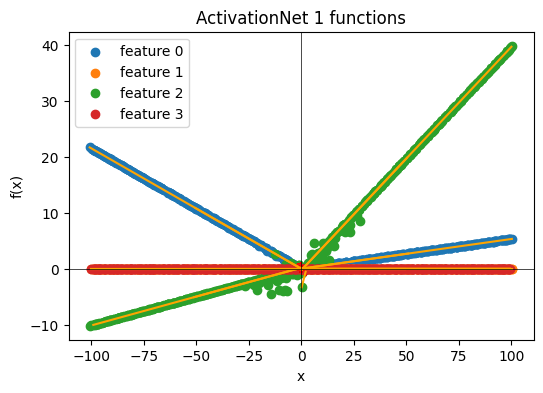

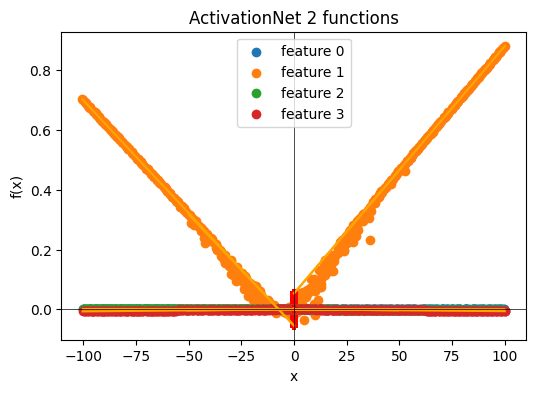

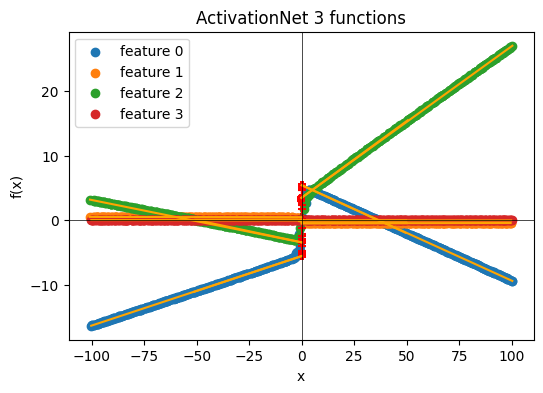

In [26]:
# (torch.rand(num_points) * 2 * x_max) - x_max for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) for _ in range(act.num_features)
# torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)

def plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3]):
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]

    for i, act in enumerate(activations, 1):
        # prepare input: each feature gets the same linspace
        xs = torch.stack([
            torch.linspace(x_min, x_max, num_points) + ((torch.rand(num_points) * 2 * 1) - 1) for _ in range(act.num_features)
        ], dim=1).to(device)   # [num_points, num_features]

        out, internal_out = act(xs)
        ys = out[1]
        ys = ys.detach().cpu().numpy()
        xs = xs.detach().cpu().numpy()

        int_xs, int_ys, _ = internal_out
        
        int_ys = int_ys.detach().cpu().numpy()
        int_xs = int_xs.detach().cpu().numpy()

        # new figure for each activation
        plt.figure(figsize=(6, 4))
        for k in select_features:
            if k < act.num_features:  # avoid index error
                plt.scatter(xs[:, k], ys[:, k], label=f"feature {k}")

                plt.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")
                
                # Number of points to select
                select_k_points = 5
                indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                # Prepare x and y pairs for all segments
                gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                # Plot all segments at once
                plt.plot(gen_data_X, gen_pred_Y, color="orange")

        plt.axhline(0, color="k", linewidth=0.5)
        plt.axvline(0, color="k", linewidth=0.5)
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title(f"ActivationNet {i} functions")
        plt.show()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)
model.eval()

plot_chain_activations(model, x_min=-100, x_max=100, num_points=512, select_features=[0,1,2,3])

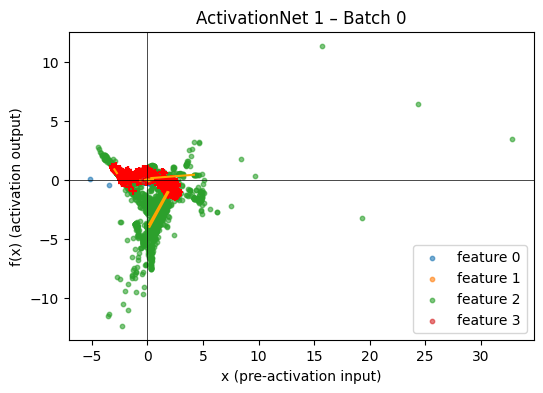

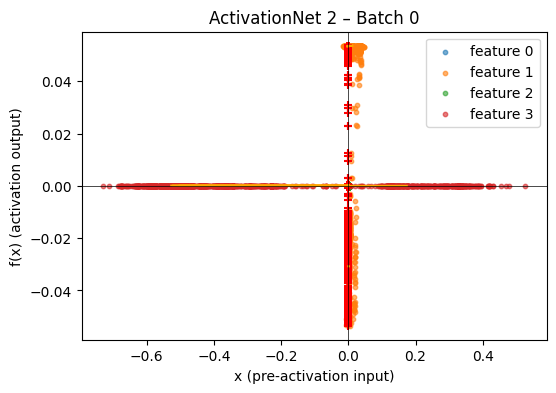

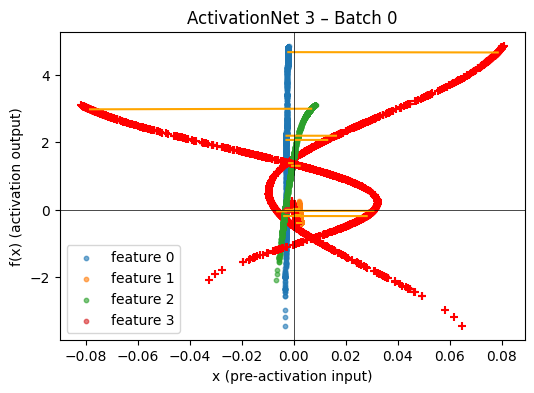

In [27]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0]):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Uses forward hooks to capture inputs and outputs of ActivationNet layers.
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = []
    for act in activations:
        hooks.append(act.register_forward_hook(hook_fn))

    # Run model on test batches
    for batch_idx, (inputs, _, _) in enumerate(test_loader):
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy(), int_ys.numpy()

            plt.figure(figsize=(6, 4))
            for k in select_features:
                if k < xs.shape[1]:  # avoid index errors
                    plt.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

                    plt.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")
        
                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    plt.plot(gen_data_X, gen_pred_Y, color="orange")
            
            plt.axhline(0, color="k", linewidth=0.5)
            plt.axvline(0, color="k", linewidth=0.5)
            plt.legend()
            plt.xlabel("x (pre-activation input)")
            plt.ylabel("f(x) (activation output)")
            plt.title(f"ActivationNet {i} – Batch {batch_idx}")
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()


if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3])

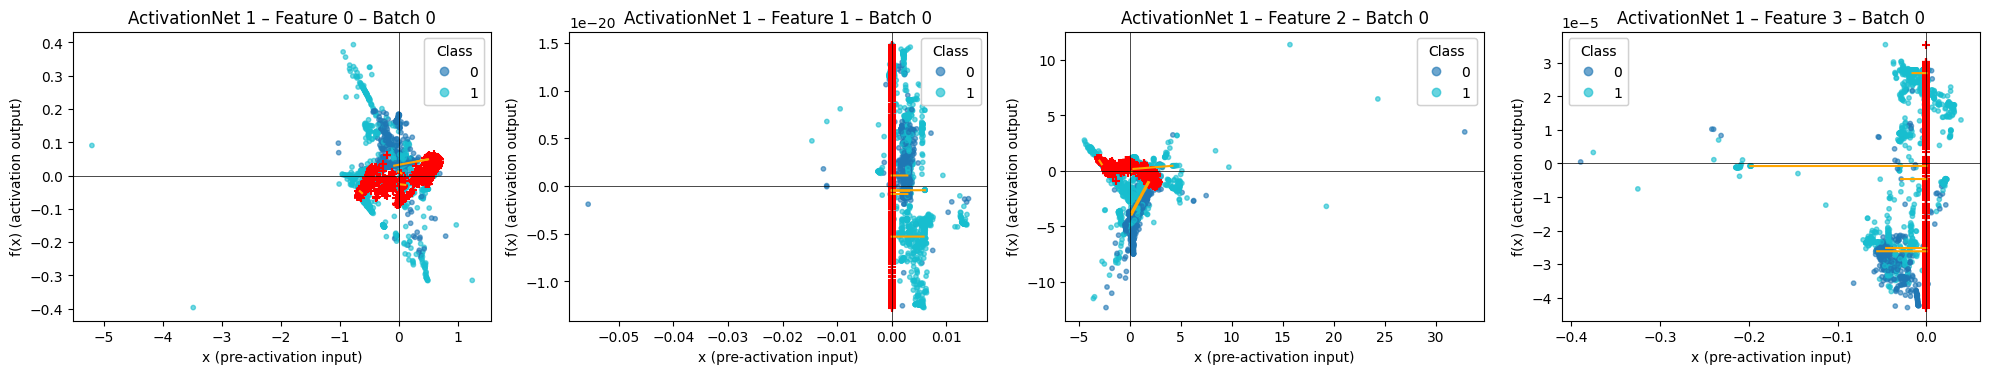

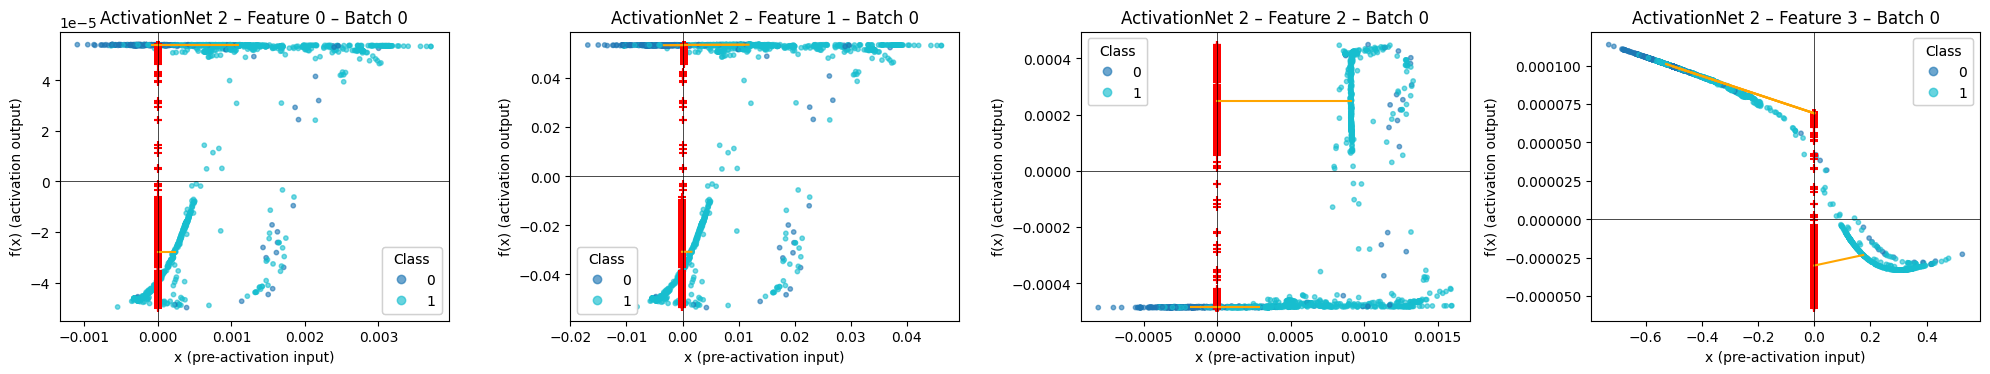

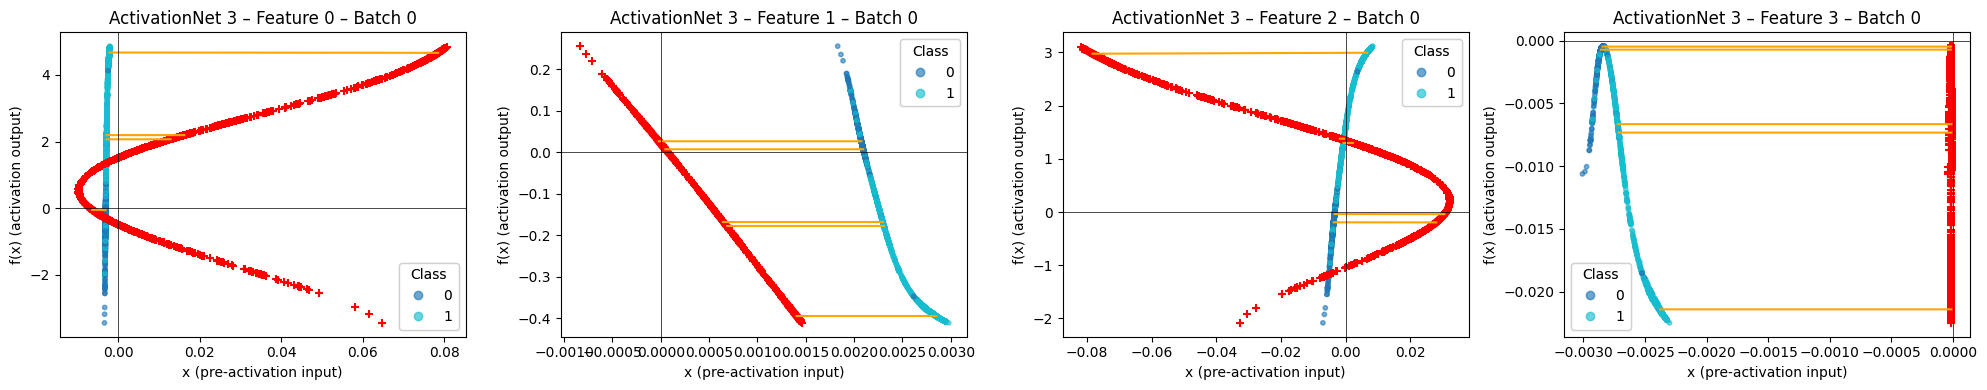

In [28]:
def plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0], color_by_class=False):
    """
    Plot activations of ActivationNet modules using data flowing through the model on test_loader.
    Each selected feature gets its own subplot instead of all being in one plot.

    Args:
        model: Trained KDD_Model instance
        test_loader: DataLoader with test dataset
        num_batches: Number of batches to visualize
        select_features: List of feature indices to plot
        color_by_class: If True, color points by class label from dataset
    """
    model.eval()
    device = next(model.parameters()).device

    # Collect activation modules
    activations = [m for m in model.modules() if isinstance(m, ActivationNet)]
    act_inputs, act_outputs = [], []

    # Hook to capture activations
    def hook_fn(module, inputs, outputs):
        act_inputs.append(inputs[0].detach().cpu())
        main_out, internal_out = outputs
        y = main_out[1]
        int_x, int_y, _ = internal_out
        act_outputs.append([y.detach().cpu(), int_x.detach().cpu(), int_y.detach().cpu()])

    # Register hooks
    hooks = [act.register_forward_hook(hook_fn) for act in activations]

    # Run model on test batches
    for batch_idx, (inputs, labels, _) in enumerate(test_loader):  # assuming dataset returns (x, y, extra)
        if batch_idx >= num_batches:
            break

        inputs = inputs.to(device)
        labels = labels.cpu().numpy() if color_by_class else None

        with torch.no_grad():
            _ = model(inputs)  # forward pass, hooks will store activations

        # Plot each ActivationNet
        for i, (xs, act_output) in enumerate(zip(act_inputs, act_outputs), 1):
            ys, int_xs, int_ys = act_output
            xs, ys = xs.numpy(), ys.numpy()
            int_xs, int_ys = int_xs.numpy(), int_ys.numpy()

            feats = [k for k in select_features if k < xs.shape[1]]
            n_feats = len(feats)
            if n_feats == 0:
                continue

            fig, axes = plt.subplots(1, n_feats, figsize=(5 * n_feats, 4), squeeze=False)

            for j, k in enumerate(feats):
                ax = axes[0, j]

                if color_by_class and labels is not None:
                    scatter = ax.scatter(xs[:, k], ys[:, k], c=labels, cmap="tab10", s=10, alpha=0.6)

                    ax.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    legend1 = ax.legend(*scatter.legend_elements(), title="Class")
                    ax.add_artist(legend1)
                else:
                    ax.scatter(xs[:, k], ys[:, k], s=10, alpha=0.6, label=f"feature {k}")

                    ax.scatter(int_xs[:, k], int_ys[:, k], marker="+", color="red")

                    # Number of points to select
                    select_k_points = 5
                    indices = np.linspace(0, len(int_xs)-1, select_k_points, dtype=int)
                    # Prepare x and y pairs for all segments
                    gen_data_X = np.column_stack([int_xs[indices, k], xs[indices, k]]).T   # shape (2, k)
                    gen_pred_Y = np.column_stack([int_ys[indices, k], ys[indices, k]]).T   # shape (2, k)
                    # Plot all segments at once
                    ax.plot(gen_data_X, gen_pred_Y, color="orange")
                    
                    ax.legend()

                ax.axhline(0, color="k", linewidth=0.5)
                ax.axvline(0, color="k", linewidth=0.5)
                ax.set_xlabel("x (pre-activation input)")
                ax.set_ylabel("f(x) (activation output)")
                ax.set_title(f"ActivationNet {i} – Feature {k} – Batch {batch_idx}")

            plt.tight_layout()
            plt.show()

        # Clear after each batch to avoid accumulation
        act_inputs.clear()
        act_outputs.clear()

    # Remove hooks after plotting
    for h in hooks:
        h.remove()

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)

plot_activations_from_data(model, test_loader, num_batches=1, select_features=[0, 1, 2, 3], color_by_class=True)

In [52]:
input_features = X_train_scaled.shape[1]

class ActivationNet(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        self.layer = nn.Linear(num_features, 32)
        self.y0_head = nn.Linear(32, num_features)
        self.m_head  = nn.Linear(32, num_features)
        self.x0_head = nn.Linear(32, num_features)
        self.combine = nn.Linear(3 * num_features, 3 * num_features)

    def forward(self, x):
        h = self.layer(x)
        h = torch.tanh(h)
        y0 = self.y0_head(h)
        m  = self.m_head(h)
        x0 = self.x0_head(h)
        params = torch.cat([y0, m, x0], dim=-1)
        params = self.combine(params)
        y0, m, x0 = torch.split(params, self.num_features, dim=1)
        y = y0 + m * (x - x0)
        return y
        
class KDD_Model(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.layer1 = nn.Linear(input_features, 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
        self.activation1 = ActivationNet(num_features=128)

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.activation2 = ActivationNet(num_features=64)
        
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(num_features=32)
        self.activation3 = ActivationNet(num_features=32)

        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.bn1(self.layer1(x))
        x = self.activation1(x)
        
        x = self.bn2(self.layer2(x))
        x = self.activation2(x)

        x = self.bn3(self.layer3(x))
        x = self.activation3(x)

        x = self.output_layer(x)
        return x

def collect_activations(model, loader, device, layer_num):
    """
    Run data through a specific block of the model and collect activations.
    layer_num: 1, 2, or 3
    """
    model.eval()
    acts = []

    with torch.no_grad():
        for xb, _, _ in loader:
            xb = xb.to(device)

            if layer_num == 1:
                xb = model.layer1(xb)
                xb = model.bn1(xb)
                xb = model.activation1(xb)
            elif layer_num == 2:
                xb = model.bn1(model.layer1(xb))
                xb = model.activation1(xb)
                xb = model.bn2(model.layer2(xb))
                xb = model.activation2(xb)
            elif layer_num == 3:
                xb = model.bn1(model.layer1(xb))
                xb = model.activation1(xb)
                xb = model.bn2(model.layer2(xb))
                xb = model.activation2(xb)
                xb = model.bn3(model.layer3(xb))
                xb = model.activation3(xb)

            acts.append(xb.cpu())

    acts = torch.cat(acts, dim=0)  # [N, features]
    return acts

def prune_block(layer, bn, activation, next_layer, alive_indices):
    # prune current layer output (rows)
    new_layer = nn.Linear(layer.in_features, len(alive_indices), bias=True)
    new_layer.weight.data = layer.weight.data[alive_indices].clone()
    new_layer.bias.data   = layer.bias.data[alive_indices].clone()

    # prune batchnorm
    new_bn = nn.BatchNorm1d(len(alive_indices))
    new_bn.weight.data = bn.weight.data[alive_indices].clone()
    new_bn.bias.data   = bn.bias.data[alive_indices].clone()
    new_bn.running_mean = bn.running_mean[alive_indices].clone()
    new_bn.running_var  = bn.running_var[alive_indices].clone()

    # prune activation
    new_activation = ActivationNet(num_features=len(alive_indices))
    new_activation.layer.weight.data = activation.layer.weight.data[:, alive_indices].clone()
    new_activation.layer.bias.data   = activation.layer.bias.data.clone()
    
    new_activation.y0_head.weight.data = activation.y0_head.weight.data[alive_indices].clone()
    new_activation.y0_head.bias.data = activation.y0_head.bias.data[alive_indices].clone()
    
    new_activation.m_head.weight.data = activation.m_head.weight.data[alive_indices].clone()
    new_activation.m_head.bias.data = activation.m_head.bias.data[alive_indices].clone()

    new_activation.x0_head.weight.data = activation.x0_head.weight.data[alive_indices].clone()
    new_activation.x0_head.bias.data = activation.x0_head.bias.data[alive_indices].clone()

    idx_3 = torch.cat([alive_indices, alive_indices + activation.num_features, alive_indices + 2 * activation.num_features])

    new_activation.combine.weight.data = activation.combine.weight.data[:, idx_3].clone()[idx_3, :]
    new_activation.combine.bias.data   = activation.combine.bias.data[idx_3].clone()

    # prune next layer input (cols)
    new_next_layer = nn.Linear(len(alive_indices), next_layer.out_features, bias=True)
    new_next_layer.weight.data = next_layer.weight.data[:, alive_indices].clone()
    new_next_layer.bias.data   = next_layer.bias.data.clone()

    return new_layer, new_bn, new_activation, new_next_layer

def prune_model(model, p_model, train_loader, device, threshold=1e-5):
    
    # ---- Block 1 ----
    acts1 = collect_activations(p_model, train_loader, device, layer_num=1)
    mask1 = (acts1.abs().mean(dim=0) >= threshold)
    idx1 = torch.where(mask1)[0]

    p_model.layer1, p_model.bn1, p_model.activation1, p_model.layer2 = prune_block(
        p_model.layer1, p_model.bn1, p_model.activation1, p_model.layer2, idx1
    )

    # ---- Block 2 ----
    acts2 = collect_activations(p_model, train_loader, device, layer_num=2)
    mask2 = (acts2.abs().mean(dim=0) >= threshold)
    idx2 = torch.where(mask2)[0]

    p_model.layer2, p_model.bn2, p_model.activation2, p_model.layer3 = prune_block(
        p_model.layer2, p_model.bn2, p_model.activation2, p_model.layer3, idx2
    )

    # ---- Block 3 ----
    acts3 = collect_activations(p_model, train_loader, device, layer_num=3)
    mask3 = (acts3.abs().mean(dim=0) >= threshold)
    idx3 = torch.where(mask3)[0]

    p_model.layer3, p_model.bn3, p_model.activation3, p_model.output_layer = prune_block(
        p_model.layer3, p_model.bn3, p_model.activation3, p_model.output_layer, idx3
    )

    return p_model

p_model = KDD_Model(input_features)
p_model = p_model.to(device)

model = KDD_Model(input_features)
model = model.to(device)

if os.path.exists(BEST_MODEL_PATH):
    # Load the best checkpoint
    print("Load the best checkpoint")
    checkpoint = torch.load(BEST_MODEL_PATH)
    model.load_state_dict(checkpoint)
    p_model.load_state_dict(checkpoint)
model.eval()
p_model.eval()

# prune whole model after training
p_model = prune_model(model.to("cpu"), p_model.to("cpu"), train_loader, device="cpu", threshold=1e-20)
p_model = p_model.to(device)
model = model.to(device)
p_model.eval()

Load the best checkpoint


KDD_Model(
  (layer1): Linear(in_features=41, out_features=112, bias=True)
  (bn1): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ActivationNet(
    (layer): Linear(in_features=112, out_features=32, bias=True)
    (y0_head): Linear(in_features=32, out_features=112, bias=True)
    (m_head): Linear(in_features=32, out_features=112, bias=True)
    (x0_head): Linear(in_features=32, out_features=112, bias=True)
    (combine): Linear(in_features=336, out_features=336, bias=True)
  )
  (layer2): Linear(in_features=112, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ActivationNet(
    (layer): Linear(in_features=64, out_features=32, bias=True)
    (y0_head): Linear(in_features=32, out_features=64, bias=True)
    (m_head): Linear(in_features=32, out_features=64, bias=True)
    (x0_head): Linear(in_features=32, out_features=64, bias=True)
    (combine): Linea

In [53]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

# usage
total_params_m, trainable_params_m = count_parameters(model)
print(f"Total parameters of model: {total_params_m:,}")
print(f"Trainable parameters of model: {trainable_params_m:,}")

# usage
total_params_p, trainable_params_p = count_parameters(p_model)
print(f"Total parameters of p_model: {total_params_p:,}")
print(f"Trainable parameters of p_model: {trainable_params_p:,}")

print(f"Total reduction: {((total_params_m - total_params_p) / total_params_m) * 100}")

Total parameters of model: 239,841
Trainable parameters of model: 239,841
Total parameters of p_model: 201,409
Trainable parameters of p_model: 201,409
Total reduction: 16.02394919967812


In [54]:
# Evaluation Function

@torch.no_grad()
def evaluate_model_threshold(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_count = 0

    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc=f"Testing", leave=True)

    for inputs, labels, _ in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device).view(-1).long()
        outputs = model(inputs)

        # logits -> probs
        probs = torch.sigmoid(outputs.view(-1))
        preds = (probs >= THRESH).long()

        # per-sample loss (no weights on test unless you have a test weight vector)
        losses = loss_fn(outputs.view(-1), labels.float()).mean()

        batch_size = labels.size(0)
        total_loss += losses.item() * batch_size
        total_count += batch_size

        all_preds.append(preds.detach().cpu())
        all_labels.append(labels.detach().cpu())

        progress_bar.set_postfix(loss=total_loss / total_count)

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Accuracy via thresholded preds
    acc = (all_preds == all_labels).mean()

    # Macro P/R/F1 (over classes 0 and 1)
    p, r, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    avg_loss = total_loss / total_count
    return avg_loss, acc, p, r, f1

In [55]:
test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        model, test_loader, loss_fn, device
    )
print(
    f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
    f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
)

test_loss, test_acc, test_p, test_r, test_f1 = evaluate_model_threshold(
        p_model, test_loader, loss_fn, device
    )
print(
    f"Test Loss: {test_loss:.4f}, Acc(th={THRESH}): {test_acc:.4f}, "
    f"P: {test_p:.4f}, R: {test_r:.4f}, F1: {test_f1:.4f}"
)

Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.99it/s, loss=0.398]


Test Loss: 0.3979, Acc(th=0.5): 0.9360, P: 0.9347, R: 0.9349, F1: 0.9348


Testing: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 81.18it/s, loss=0.404]

Test Loss: 0.4040, Acc(th=0.5): 0.9340, P: 0.9332, R: 0.9322, F1: 0.9327
